Copyright (c) 2021 [윤기태]

https://github.com/yoonkt200/learning-spoons-nano-degree

[MIT License](https://github.com/yoonkt200/learning-spoons-nano-degree/blob/master/LICENSE.txt)

# LearningSpoons - NanoDegree

-----

# 3회차 - (주문데이터, 배송데이터 분석)

- [1. 주문데이터 전처리](#1.-주문데이터-전처리)
    - [데이터 병합 및 탐색]
    - [데이터 전처리]
- [2. 시간대별 주문데이터 분석](#2.-시간대별-주문데이터-분석)
    - [시간대별 주문량 분석]
    - [시간대별 주문 지역 분석]
- [3. 주문 상품 카테고리 분석](#3.-주문-상품-카테고리-분석)
    - [상품 및 카테고리 탐색]
    - [카테고리 주문 비중 분석]
    - [시간/요일별 주문 카테고리 분석]
- [4. 배송 데이터 분석](#4.-배송-데이터-분석)
    - [평균 배송 시간 분석]
    - [지역별 배송 정보 분석]
    - [예상 배송일과 실제 배송일 차이 분석]
    - [카테고리별 배송 데이터 분석]
- [5. 심화 예제](#5.-심화-예제)
    - [워드 클라우드 예제]
    - [감성분류로 텍스트 스코어 추출하기]

----

- 강의 순서
    - 각종 EDA 케이스를 통해, Data Preprocessing과 데이터를 탐색하는 법을 공부합니다.
    - 데이터를 시각화하여 피쳐를 살펴보는 연습을 진행합니다.
    - 리포트에 활용될 수 있는 인터렉션 시각화를 연습합니다.
    - 탐색한 데이터를 심화 예제들을 통해 활용합니다.
    
- 숙제
    - 1. Bokeh 라이브러리를 활용하여, 지역별 주문 카테고리 분석하기
    - 2. 회귀분석 원리 공부하기 (키워드 : OLS, MSE, Gradient Descent)

In [1]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = "../dataset/"

# 1. 주문데이터 전처리

### [데이터 병합 및 탐색]

----
#### *주문데이터 기준으로 데이터 병합*

In [3]:
order_df = pd.read_csv(data_dir + "olist_order_items_dataset.csv")
shipping_df = pd.read_csv(data_dir + "olist_orders_dataset.csv")
category_df = pd.read_csv(data_dir + "olist_products_dataset.csv")
user_df = pd.read_csv(data_dir + "olist_customers_dataset.csv")
location_df = pd.read_csv(data_dir + "olist_geolocation_dataset.csv")
product_category_name_translation_df = pd.read_csv(data_dir + "product_category_name_translation.csv")

In [4]:
order_df['order_id'] = order_df['order_id'].astype(str)
shipping_df['order_id'] = shipping_df['order_id'].astype(str)
order_df = order_df.merge(shipping_df, how='left', on='order_id')

In [5]:
order_df['product_id'] = order_df['product_id'].astype(str)
category_df['product_id'] = category_df['product_id'].astype(str)
order_df = order_df.merge(category_df, how='left', on='product_id')

In [6]:
order_df['customer_id'] = order_df['customer_id'].astype(str)
user_df['customer_id'] = user_df['customer_id'].astype(str)
order_df = order_df.merge(user_df, how='left', on='customer_id')

In [7]:
location_df.head()

,geolocation_zip_code_prefix,geolocation_lat,geolocation_lng,geolocation_city,geolocation_state
0,1037,-23.545621,-46.639292,sao paulo,SP
1,1046,-23.546081,-46.644820,sao paulo,SP
2,1046,-23.546129,-46.642951,sao paulo,SP
3,1041,-23.544392,-46.639499,sao paulo,SP
4,1035,-23.541578,-46.641607,sao paulo,SP


In [8]:
order_df['customer_zip_code_prefix'] = order_df['customer_zip_code_prefix'].astype(str)
location_df['geolocation_zip_code_prefix'] = location_df['geolocation_zip_code_prefix'].astype(str)
location_df.columns = ['customer_zip_code_prefix', 'lat', 'lng', 'city', 'state']
order_df = order_df.merge(location_df, how='left', on='customer_zip_code_prefix')

In [9]:
order_df['product_category_name'] = order_df['product_category_name'].astype(str)
product_category_name_translation_df['product_category_name'] = product_category_name_translation_df['product_category_name'].astype(str)
order_df = order_df.merge(product_category_name_translation_df, how='left', on='product_category_name')

In [10]:
order_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,customer_id,order_status,order_purchase_timestamp,...,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,lat,lng,city,state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758076,-41.312633,campos dos goytacazes,RJ,cool_stuff
1,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.758843,-41.306754,campos dos goytacazes,RJ,cool_stuff
2,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.767046,-41.311328,campos dos goytacazes,RJ,cool_stuff
3,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.771661,-41.312119,campos dos goytacazes,RJ,cool_stuff
4,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,...,14.0,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.763006,-41.306182,campos dos goytacazes,RJ,cool_stuff


In [11]:
order_df.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'product_category_name',
       'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state', 'lat',
       'lng', 'city', 'state', 'product_category_name_english'],
      dtype='object')

In [12]:
anal_columns = ['order_id', 'product_id', 'customer_id',
                'order_item_id', 'price', 'freight_value', 
                'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date',
                'product_category_name_english',
                'customer_zip_code_prefix', 'lat', 'lng', 'city', 'state',
                ]

In [13]:
order_df = order_df[anal_columns]

In [14]:
order_df.head()

,order_id,product_id,customer_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,product_category_name_english,customer_zip_code_prefix,lat,lng,city,state
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,28013,-21.758076,-41.312633,campos dos goytacazes,RJ
1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,28013,-21.758843,-41.306754,campos dos goytacazes,RJ
2,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,28013,-21.767046,-41.311328,campos dos goytacazes,RJ
3,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,28013,-21.771661,-41.312119,campos dos goytacazes,RJ
4,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.9,13.29,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00,cool_stuff,28013,-21.763006,-41.306182,campos dos goytacazes,RJ


----
#### *데이터 정보 탐색*

In [15]:
order_df.isnull().sum()

order_id                              0
product_id                            0
customer_id                           0
order_item_id                         0
price                                 0
freight_value                         0
order_status                          0
order_purchase_timestamp              0
order_approved_at                  2994
order_delivered_customer_date    353455
order_estimated_delivery_date         0
product_category_name_english    243995
customer_zip_code_prefix              0
lat                                 302
lng                                 302
city                                302
state                               302
dtype: int64

In [16]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17196183 entries, 0 to 17196182
Data columns (total 17 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   order_id                       object 
 1   product_id                     object 
 2   customer_id                    object 
 3   order_item_id                  int64  
 4   price                          float64
 5   freight_value                  float64
 6   order_status                   object 
 7   order_purchase_timestamp       object 
 8   order_approved_at              object 
 9   order_delivered_customer_date  object 
 10  order_estimated_delivery_date  object 
 11  product_category_name_english  object 
 12  customer_zip_code_prefix       object 
 13  lat                            float64
 14  lng                            float64
 15  city                           object 
 16  state                          object 
dtypes: float64(4), int64(1), object(12)
memory u

In [17]:
order_df.describe()

,order_item_id,price,freight_value,lat,lng
count,1.719618e+07,1.719618e+07,1.719618e+07,1.719588e+07,1.719588e+07
mean,1.206617e+00,1.213903e+02,1.955551e+01,-2.197089e+01,-4.594655e+01
std,7.047700e-01,1.855548e+02,1.488239e+01,4.286700e+00,3.556224e+00
min,1.000000e+00,8.500000e-01,0.000000e+00,-3.660537e+01,-1.014668e+02
25%,1.000000e+00,3.990000e+01,1.347000e+01,-2.357682e+01,-4.763781e+01
50%,1.000000e+00,7.500000e+01,1.623000e+01,-2.291130e+01,-4.645801e+01
75%,1.000000e+00,1.359000e+02,2.025000e+01,-2.042241e+01,-4.335192e+01
max,2.100000e+01,6.735000e+03,4.096800e+02,4.506593e+01,1.382021e+01


In [18]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [19]:
order_df.describe()

,order_item_id,price,freight_value,lat,lng
count,17196183.000,17196183.000,17196183.000,17195881.000,17195881.000
mean,1.207,121.390,19.556,-21.971,-45.947
std,0.705,185.555,14.882,4.287,3.556
min,1.000,0.850,0.000,-36.605,-101.467
25%,1.000,39.900,13.470,-23.577,-47.638
50%,1.000,75.000,16.230,-22.911,-46.458
75%,1.000,135.900,20.250,-20.422,-43.352
max,21.000,6735.000,409.680,45.066,13.820


In [20]:
order_df['order_status'].value_counts()

delivered      16843008
shipped          156562
canceled          76890
invoiced          60740
processing        57084
unavailable        1241
approved            658
Name: order_status, dtype: int64

In [21]:
order_df[['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date']]

,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date
0,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00
1,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00
2,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00
3,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00
4,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,2017-09-29 00:00:00
...,...,...,...,...
17196178,2018-06-09 17:00:18,2018-06-09 17:10:13,2018-06-14 17:56:26,2018-06-28 00:00:00
17196179,2018-06-09 17:00:18,2018-06-09 17:10:13,2018-06-14 17:56:26,2018-06-28 00:00:00
17196180,2018-06-09 17:00:18,2018-06-09 17:10:13,2018-06-14 17:56:26,2018-06-28 00:00:00
17196181,2018-06-09 17:00:18,2018-06-09 17:10:13,2018-06-14 17:56:26,2018-06-28 00:00:00


In [23]:
order_df[['customer_zip_code_prefix', 'city', 'state']]

,customer_zip_code_prefix,city,state
0,28013,campos dos goytacazes,RJ
1,28013,campos dos goytacazes,RJ
2,28013,campos dos goytacazes,RJ
3,28013,campos dos goytacazes,RJ
4,28013,campos dos goytacazes,RJ
...,...,...,...
17196178,18605,botucatu,SP
17196179,18605,botucatu,SP
17196180,18605,botucatu,SP
17196181,18605,botucatu,SP


In [27]:
order_df['customer_zip_code_prefix'].value_counts()

24220    166170
24230    147668
22790    105798
38400     93605
35500     90700
          ...  
12341         1
74686         1
96115         1
2140          1
38710         1
Name: customer_zip_code_prefix, Length: 14976, dtype: int64

In [28]:
order_df['customer_zip_code_prefix'].value_counts().describe()

count    14976.000
mean      1148.249
std       4459.435
min          1.000
25%         38.000
50%        168.000
75%        702.000
max     166170.000
Name: customer_zip_code_prefix, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d80f6d6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d80f6ddf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d80f6d340>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9d80f77550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9d80f778e0>],
 'means': []}

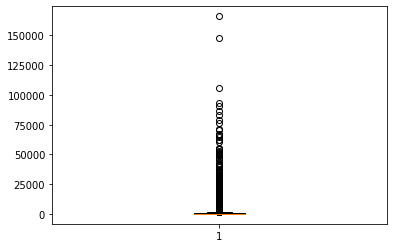

In [29]:
plt.boxplot(order_df['customer_zip_code_prefix'].value_counts())

In [24]:
order_df['city'].value_counts()

rio de janeiro       2185517
sao paulo            1333209
belo horizonte        850346
niteroi               455864
curitiba              295003
                      ...   
termas de ibira            1
amapa do maranhao          1
japaraíba                  1
valao do barro             1
fernão                     1
Name: city, Length: 5801, dtype: int64

In [25]:
order_df['city'].value_counts().describe()

count      5801.000
mean       2964.296
std       37717.499
min           1.000
25%          13.000
50%          62.000
75%         468.000
max     2185517.000
Name: city, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d89f555b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d89f55c10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d89f55160>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9d89f64370>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9d89f64700>],
 'means': []}

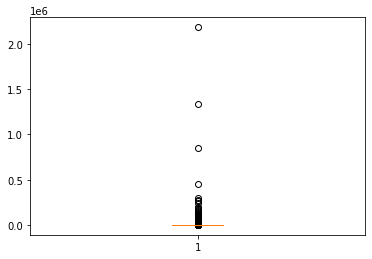

In [26]:
plt.boxplot(order_df['city'].value_counts())

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9db96f3df0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9db9704550>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9db96f3a60>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9db9704c70>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9db9711040>],
 'means': []}

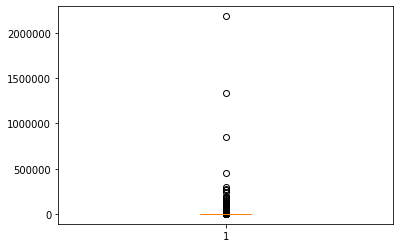

In [30]:
plt.ticklabel_format(style='plain')
plt.boxplot(order_df['city'].value_counts())

In [31]:
order_df['state'].value_counts()

SP    6396807
RJ    3443647
MG    3277695
RS     925129
PR     716308
SC     625259
BA     416850
ES     353706
GO     154963
MT     145417
PE     127671
DF     105419
PA      93342
CE      71497
MS      71107
MA      59755
AL      36573
PB      31573
SE      27214
PI      26490
RO      23767
RN      23212
TO      19888
AC       8332
AM       6267
AP       5582
RR       2411
Name: state, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9dab14d760>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9dab14de80>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9dab14d3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9dab1595e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9dab159970>],
 'means': []}

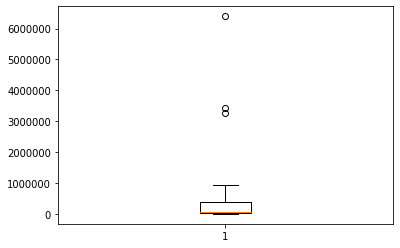

In [32]:
plt.ticklabel_format(style='plain')
plt.boxplot(order_df['state'].value_counts())

### [데이터 전처리]

----
#### *열 타입 변경*

In [33]:
order_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17196183 entries, 0 to 17196182
Data columns (total 17 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   order_id                       object 
 1   product_id                     object 
 2   customer_id                    object 
 3   order_item_id                  int64  
 4   price                          float64
 5   freight_value                  float64
 6   order_status                   object 
 7   order_purchase_timestamp       object 
 8   order_approved_at              object 
 9   order_delivered_customer_date  object 
 10  order_estimated_delivery_date  object 
 11  product_category_name_english  object 
 12  customer_zip_code_prefix       object 
 13  lat                            float64
 14  lng                            float64
 15  city                           object 
 16  state                          object 
dtypes: float64(4), int64(1), object(12)
memory u

In [34]:
order_df['order_purchase_timestamp'] = pd.to_datetime(order_df['order_purchase_timestamp'])
order_df['order_approved_at'] = pd.to_datetime(order_df['order_approved_at'])
order_df['order_delivered_customer_date'] = pd.to_datetime(order_df['order_delivered_customer_date'])
order_df['order_estimated_delivery_date'] = pd.to_datetime(order_df['order_estimated_delivery_date'])

In [35]:
order_df['order_purchase_timestamp'][0]

Timestamp('2017-09-13 08:59:02')

In [36]:
order_df['order_purchase_timestamp'][0].year

2017

----
#### *배송 완료 필터링*

In [37]:
order_df['order_status'].value_counts()

delivered      16843008
shipped          156562
canceled          76890
invoiced          60740
processing        57084
unavailable        1241
approved            658
Name: order_status, dtype: int64

In [38]:
16843008 / order_df.shape[0]

0.9794620120058039

In [39]:
order_df = order_df[order_df['order_status']=='delivered']

In [40]:
order_df.shape

(16843008, 17)

----
#### *결측치 & 이상치 처리*

In [41]:
order_df.isnull().sum()

order_id                              0
product_id                            0
customer_id                           0
order_item_id                         0
price                                 0
freight_value                         0
order_status                          0
order_purchase_timestamp              0
order_approved_at                  2994
order_delivered_customer_date      1261
order_estimated_delivery_date         0
product_category_name_english    234556
customer_zip_code_prefix              0
lat                                 288
lng                                 288
city                                288
state                               288
dtype: int64

In [42]:
order_df = order_df.dropna()

In [43]:
order_df.isnull().sum()

order_id                         0
product_id                       0
customer_id                      0
order_item_id                    0
price                            0
freight_value                    0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_customer_date    0
order_estimated_delivery_date    0
product_category_name_english    0
customer_zip_code_prefix         0
lat                              0
lng                              0
city                             0
state                            0
dtype: int64

In [44]:
order_df.shape

(16604083, 17)

----
# 2. 시간대별 주문데이터 분석

### [시간대별 주문량 분석] - Business Analytics

----
#### *주문 일자 탐색*

In [45]:
order_df['order_purchase_timestamp'].max()

Timestamp('2018-08-29 15:00:37')

In [46]:
order_df['order_purchase_timestamp'].min()

Timestamp('2016-09-15 12:16:38')

In [47]:
order_df['order_purchase_timestamp'][0].date()

datetime.date(2017, 9, 13)

In [48]:
order_df['order_purchase_date'] = order_df['order_purchase_timestamp'].apply(lambda x: x.date())

<AxesSubplot:xlabel='order_purchase_date'>

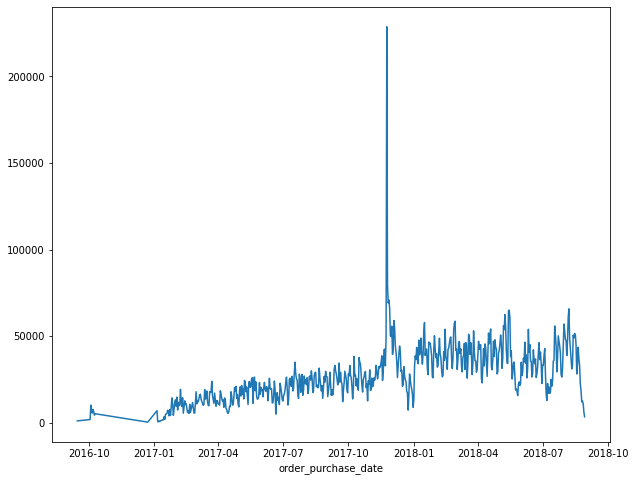

In [49]:
plt.rcParams['figure.figsize'] = [10, 8]
order_df.groupby('order_purchase_date')['order_id'].count().plot()

----
#### *주문 시간 탐색*

In [50]:
order_df['order_purchase_hour'] = order_df['order_purchase_timestamp'].apply(lambda x: x.hour)

<AxesSubplot:xlabel='order_purchase_hour'>

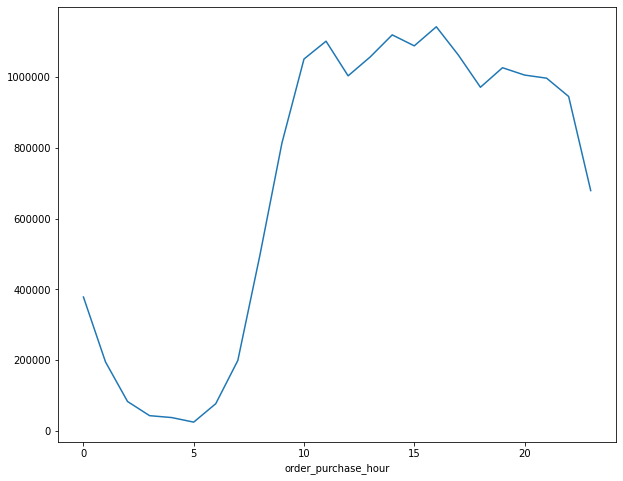

In [51]:
plt.ticklabel_format(style='plain')
plt.rcParams['figure.figsize'] = [10, 8]
order_df.groupby('order_purchase_hour')['order_id'].count().plot()

----
#### *주문 요일별 탐색*

In [52]:
order_df['order_purchase_timestamp'][0]

Timestamp('2017-09-13 08:59:02')

In [53]:
order_df['order_purchase_timestamp'][0].strftime("%A")

'Wednesday'

In [54]:
order_df['order_purchase_day_name'] = order_df['order_purchase_timestamp'].apply(lambda x: x.strftime("%A"))

In [55]:
order_purchase_day_name = order_df.groupby('order_purchase_day_name')['order_id'].count()

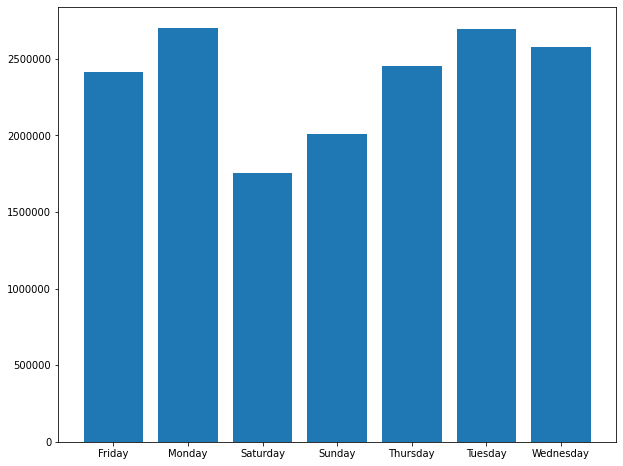

In [56]:
plt.ticklabel_format(style='plain')
plt.bar(order_purchase_day_name.index, order_purchase_day_name.values)
plt.show()

-----
### [시간대별 주문 지역 분석]

#### *bokeh 라이브러리로 지도에 주문량 시각화* - Interaction Visualization

In [71]:
# pip install bokeh
# https://docs.bokeh.org/en/latest/

from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

In [72]:
# Web Mercator 데이터 포맷으로 변환
def wgs84_to_web_mercator(df, lng, lat):
    k = 6378137
    df["x"] = df[lng] * (k * np.pi/180.0)
    df["y"] = np.log(np.tan((90 + df[lat]) * np.pi/360.0)) * k
    return df

order_df = wgs84_to_web_mercator(order_df, 'lng', 'lat')

In [73]:
# 맵의 확대 정도 지정
zoom_scale=3000
x = order_df['x']
y = order_df['y']

# 지도에서 표시할 x,y의 범위 지정
x_min = int(x.mean() - (zoom_scale * 350))
x_max = int(x.mean() + (zoom_scale * 350))
y_min = int(y.mean() - (zoom_scale * 350))
y_max = int(y.mean() + (zoom_scale * 350))

# 사용할 지도의 스타일 정의 : OSM, ESRI, google Type...
tile_provider = get_provider(OSM)

# Bokh 플롯 개체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = True

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [74]:
order_df['customer_zip_code_prefix'].nunique()

14696

In [75]:
order_df['city'].nunique()

5747

In [76]:
order_df['state'].nunique()

27

In [77]:
city_df = order_df.groupby('city').agg({'order_id' : ['count'], 'lat' : ['mean'], 'lng' : ['mean']})
city_df = city_df.reset_index()

In [78]:
city_df.head()

,city,order_id,lat,lng
,,count,mean,mean
0,* cidade,2,-25.572,-49.334
1,...arraial do cabo,37,-22.969,-42.030
2,abadia dos dourados,78,-18.474,-47.408
3,abadiania,17,-16.194,-48.708
4,abadiânia,7,-16.194,-48.712


In [79]:
city_df.columns

MultiIndex([(    'city',      ''),
            ('order_id', 'count'),
            (     'lat',  'mean'),
            (     'lng',  'mean')],
           )

In [80]:
city_df.columns = city_df.columns.to_flat_index()
city_df.columns = ['city', 'count', 'lat', 'lng']

In [81]:
city_df.head()

,city,count,lat,lng
0,* cidade,2,-25.572,-49.334
1,...arraial do cabo,37,-22.969,-42.030
2,abadia dos dourados,78,-18.474,-47.408
3,abadiania,17,-16.194,-48.708
4,abadiânia,7,-16.194,-48.712


In [82]:
city_df = wgs84_to_web_mercator(city_df, 'lng', 'lat')
city_df.head()

,city,count,lat,lng,x,y
0,* cidade,2,-25.572,-49.334,-5491877.401,-2946136.106
1,...arraial do cabo,37,-22.969,-42.030,-4678739.761,-2628314.881
2,abadia dos dourados,78,-18.474,-47.408,-5277416.222,-2093160.670
3,abadiania,17,-16.194,-48.708,-5422198.952,-1827179.099
4,abadiânia,7,-16.194,-48.712,-5422610.916,-1827148.419


In [83]:
city_df.shape

(5747, 6)

In [84]:
def bubble_map(plot, df, count_col, leg_label, lon, lat, scale):
    # color palete 지정
    mapper = LinearColorMapper(
        palette='Greys256',
        low=df[count_col].max(),
        high=df[count_col].min()
    )

    # 지도에 circle 포인트 그리기
    c = plot.circle(x='x',
                    y='y',
                    color=transform(count_col, mapper),
                    size=7,
                    alpha=0.4,
                    source=df,
                    legend_label=leg_label)
    
    # mouse hover에 표기할 정보
    tip_label='@'+count_col
    lat_label='@'+lat
    lon_label='@'+lon
    circle_hover = HoverTool(tooltips=[(count_col, tip_label), ('Lat:', lat_label), ('Lon:', lon_label)], 
                             mode='mouse', 
                             point_policy='follow_mouse', 
                             renderers=[c])
    circle_hover.renderers.append(c)
    
    # mouse hover와 legend 정보 부착
    plot.tools.append(circle_hover)
    plot.legend.location = "top_right"
    plot.legend.click_policy="hide"
    
    # color bar 정보 부착
    color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 12,
                     location = (0,0),
                     title = 'order count')
    plot.add_layout(color_bar, 'right')

In [85]:
# Create bubble map
bubble_map(plot=plot,
           df=city_df,
           count_col='count', 
           leg_label='Order Count Map',
           lon='lng',
           lat='lat',
           scale=zoom_scale)

In [86]:
# plot 시각화
show(plot)

<AxesSubplot:>

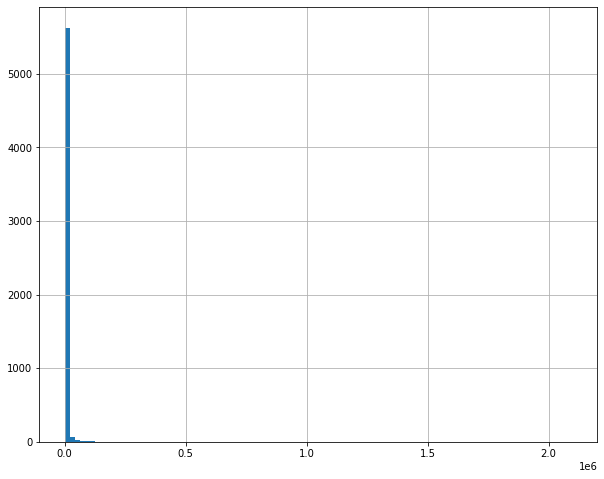

In [87]:
city_df['count'].hist(bins=100)

<AxesSubplot:>

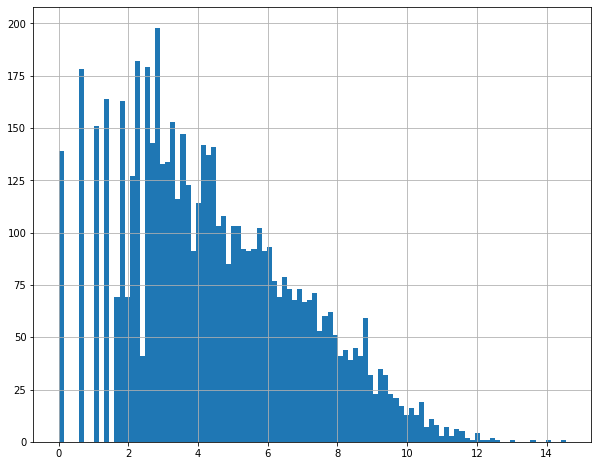

In [88]:
np.log(city_df['count']).hist(bins=100)

In [89]:
# Bokh 플롯 개체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = False

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [90]:
city_df['count'] = city_df['count'].apply(lambda x: np.log(x))

In [91]:
# Create bubble map
bubble_map(plot=plot,
           df=city_df,
           count_col='count', 
           leg_label='Order Count Map',
           lon='lng',
           lat='lat',
           scale=zoom_scale)

In [92]:
# plot 시각화
show(plot)

----
#### *시간대 나눠서 지도에 시각화*

In [93]:
order_df['order_purchase_hour'].value_counts()

16    1142434
14    1119573
11    1101672
15    1088575
17    1062453
13    1057076
10    1051316
19    1026725
20    1006005
12    1003795
21     997183
18     971515
22     945417
9      813875
23     679537
8      496463
0      378724
7      199319
1      195299
2       83380
6       77237
3       43377
4       38021
5       25112
Name: order_purchase_hour, dtype: int64

In [94]:
def split_by_time_quarter(x):
    if x <= 8:
        return "dawn_to_morning"
    else:
        if x <= 16:
            return "morning_to_midnight"
        else:
            return "midnight_to_dawn"

order_df['time_bucketized'] = order_df['order_purchase_hour'].apply(lambda x: split_by_time_quarter(x))

In [95]:
order_df['time_bucketized'].value_counts()

morning_to_midnight    8378316
midnight_to_dawn       6688835
dawn_to_morning        1536932
Name: time_bucketized, dtype: int64

In [100]:
def get_bucketized_df(df, time_bucketized):
    temp_df = df[df['time_bucketized']==time_bucketized].groupby('city').agg({'order_id' : ['count'], 'lat' : ['mean'], 'lng' : ['mean']})
    temp_df = temp_df.reset_index()
    temp_df.columns = temp_df.columns.to_flat_index()
    temp_df.columns = ['city', 'count', 'lat', 'lng']
    temp_df = wgs84_to_web_mercator(temp_df, 'lng', 'lat')
    temp_df['count'] = temp_df['count'].apply(lambda x: np.log(x))
    return temp_df

In [101]:
dawn_to_morning_city_df = get_bucketized_df(order_df, 'dawn_to_morning')

In [102]:
dawn_to_morning_city_df.head()

,city,count,lat,lng,x,y
0,...arraial do cabo,1.099,-22.969,-42.030,-4678739.761,-2628314.881
1,abadia dos dourados,3.258,-18.474,-47.408,-5277416.222,-2093160.670
2,abare,2.944,-8.690,-39.164,-4359732.575,-971092.987
3,abaré,1.386,-8.724,-39.115,-4354216.715,-974886.532
4,abelardo luz,4.060,-26.565,-52.325,-5824828.873,-3069275.293


In [103]:
morning_to_midnight_city_df = get_bucketized_df(order_df, 'morning_to_midnight')
midnight_to_dawn_city_df = get_bucketized_df(order_df, 'midnight_to_dawn')

In [104]:
# Bokh 플롯 개체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = False

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [105]:
def buketized_bubble_map(plot, df, count_col, leg_label, lon, lat, scale):
    for sub_df, l_label in zip(df, leg_label):
        # color palete 지정
        mapper = LinearColorMapper(
            palette='Greys256',
            low=sub_df[count_col].max(),
            high=sub_df[count_col].min()
        )

        # 지도에 circle 포인트 그리기
        c = plot.circle(x='x',
                        y='y',
                        color=transform(count_col, mapper),
                        size=7,
                        alpha=0.4,
                        source=sub_df,
                        legend_label=l_label)

        # mouse hover에 표기할 정보
        tip_label='@'+count_col
        lat_label='@'+lat
        lon_label='@'+lon
        circle_hover = HoverTool(tooltips=[(count_col, tip_label), ('Lat:', lat_label), ('Lon:', lon_label)], 
                                 mode='mouse', 
                                 point_policy='follow_mouse', 
                                 renderers=[c])
        circle_hover.renderers.append(c)

        # mouse hover와 legend 정보 부착
        plot.tools.append(circle_hover)
        plot.legend.location = "top_right"
        plot.legend.click_policy="hide"

    # color bar 정보 부착
    color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 12,
                     location = (0,0),
                     title = 'order count')
    plot.add_layout(color_bar, 'right')

In [106]:
# Create bubble map
buketized_bubble_map(plot=plot,
                     df=[dawn_to_morning_city_df, morning_to_midnight_city_df, midnight_to_dawn_city_df],
                     count_col='count', 
                     leg_label=['dawn_to_morning', 'morning_to_midnight', 'midnight_to_dawn'],
                     lon='lng',
                     lat='lat',
                     scale=zoom_scale)

In [107]:
# plot 시각화
show(plot)

----
# 3. 주문 상품 카테고리 분석

### [상품 및 카테고리 탐색]

----
#### *상품 기초 정보*

In [109]:
order_df.head()

,order_id,product_id,customer_id,order_item_id,price,freight_value,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,...,lat,lng,city,state,order_purchase_date,order_purchase_hour,order_purchase_day_name,x,y,time_bucketized
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.900,13.290,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,...,-21.758,-41.313,campos dos goytacazes,RJ,2017-09-13,8,Wednesday,-4598901.310,-2482504.027,dawn_to_morning
1,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.900,13.290,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,...,-21.759,-41.307,campos dos goytacazes,RJ,2017-09-13,8,Wednesday,-4598246.794,-2482595.960,dawn_to_morning
2,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.900,13.290,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,...,-21.767,-41.311,campos dos goytacazes,RJ,2017-09-13,8,Wednesday,-4598756.001,-2483579.181,dawn_to_morning
3,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.900,13.290,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,...,-21.772,-41.312,campos dos goytacazes,RJ,2017-09-13,8,Wednesday,-4598843.995,-2484132.399,dawn_to_morning
4,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,3ce436f183e68e07877b285a838db11a,1,58.900,13.290,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-20 23:43:48,...,-21.763,-41.306,campos dos goytacazes,RJ,2017-09-13,8,Wednesday,-4598183.140,-2483094.891,dawn_to_morning


In [111]:
order_df['product_id'].nunique()

31573

In [113]:
order_df['product_id'].value_counts()

aca2eb7d00ea1a7b8ebd4e68314663af    81286
422879e10f46682990de24d770e7f83d    78420
99a4788cb24856965c36a24e339b6058    72993
389d119b48cf3043d311335e499d9c6b    58319
368c6c730842d78016ad823897a372db    55853
                                    ...  
fd52a24b7fa473a6c7a62a5ee7579def        1
9da1c863c2389407fa1da532a5238d47        1
31aaae9f2af6869bff6b8cbbaf195e65        1
2a714dc40b27bbd0887215ed0cdc3bbe        1
b80b06f3f098c07cd2c8116aa3f1a7ed        1
Name: product_id, Length: 31573, dtype: int64

<AxesSubplot:>

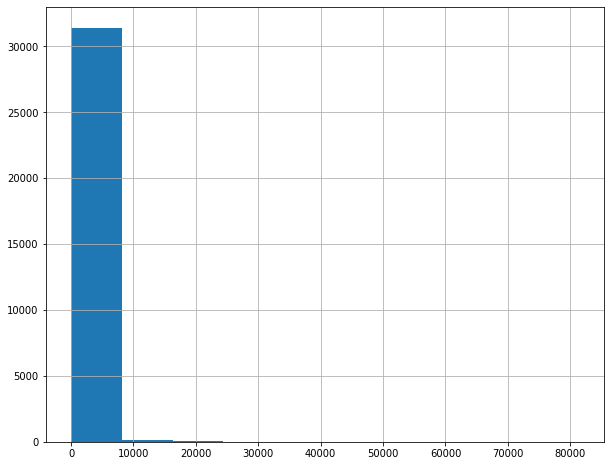

In [114]:
order_df['product_id'].value_counts().hist()

<AxesSubplot:>

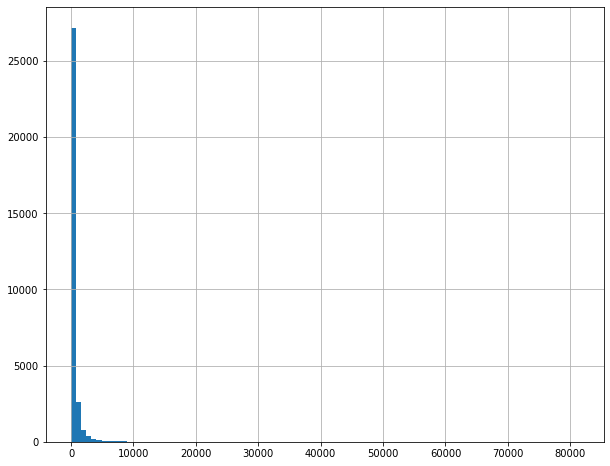

In [115]:
order_df['product_id'].value_counts().hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9a3833b6d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9a3833bdf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9a3833b340>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9a38347550>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9a383478e0>],
 'means': []}

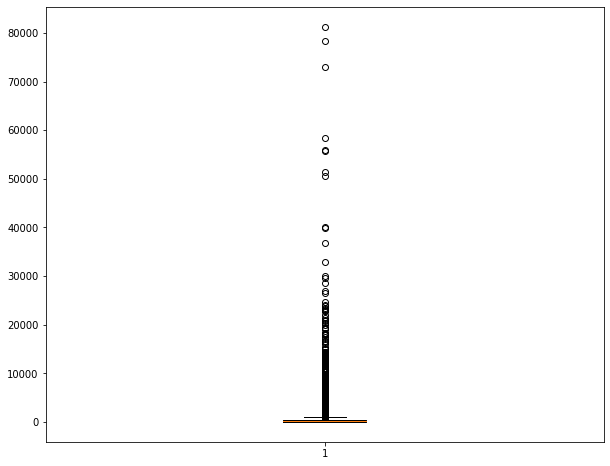

In [116]:
plt.boxplot(order_df['product_id'].value_counts())

In [117]:
order_df['product_id'].value_counts().describe()

count   31573.000
mean      525.895
std      1631.961
min         1.000
25%        87.000
50%       200.000
75%       480.000
max     81286.000
Name: product_id, dtype: float64

<AxesSubplot:>

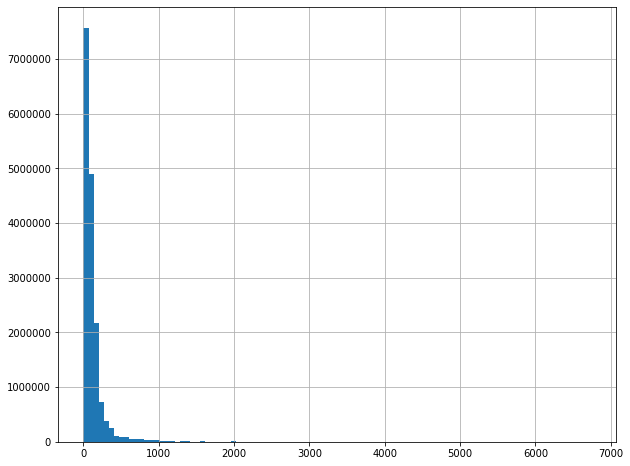

In [165]:
plt.ticklabel_format(style='plain', axis='y')
order_df['price'].hist(bins=100)

<AxesSubplot:>

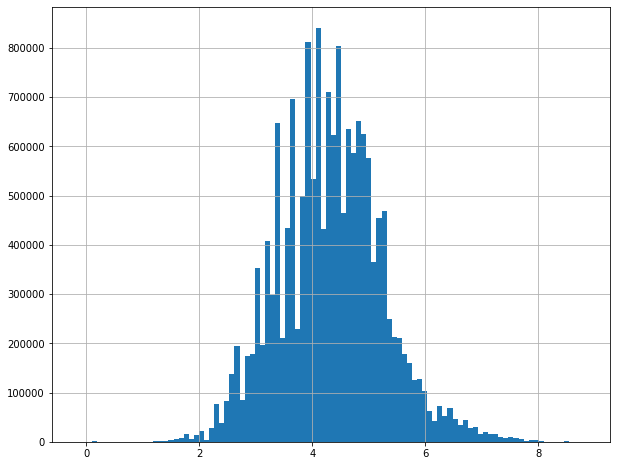

In [120]:
np.log(order_df['price']).hist(bins=100)

<AxesSubplot:>

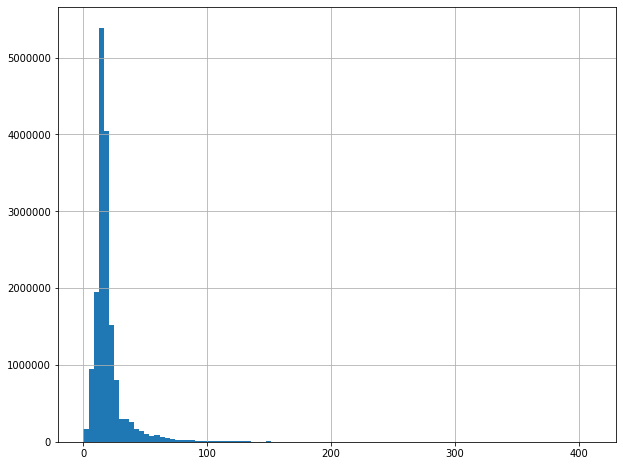

In [164]:
plt.ticklabel_format(style='plain', axis='y')
order_df['freight_value'].hist(bins=100)

In [124]:
order_df['freight_value'].describe()

count   16604083.000
mean          19.562
std           14.851
min            0.000
25%           13.470
50%           16.250
75%           20.290
max          409.680
Name: freight_value, dtype: float64

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9dab74aa60>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9dab7581c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9dab73d790>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9dab758910>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9dab758ca0>],
 'means': []}

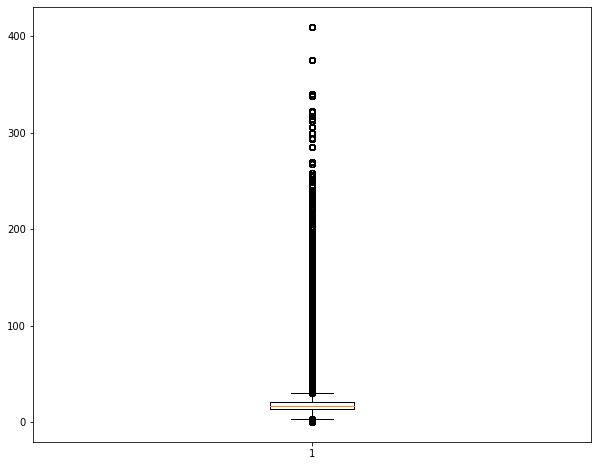

In [126]:
plt.boxplot(order_df['freight_value'])

In [128]:
order_df.groupby('product_id').agg({'order_id' : ['count'], 'price' : ['mean']}).reset_index()

,product_id,order_id,price
,,count,mean
0,00066f42aeeb9f3007548bb9d3f33c38,153,101.650
1,00088930e925c41fd95ebfe695fd2655,438,129.900
2,0009406fd7479715e4bef61dd91f2462,44,229.000
3,000b8f95fcb9e0096488278317764d19,42,58.900
4,000d9be29b5207b54e86aa1b1ac54872,115,199.000
...,...,...,...
31568,fff6177642830a9a94a0f2cba5e476d1,69,115.352
31569,fff81cc3158d2725c0655ab9ba0f712c,33,90.000
31570,fff9553ac224cec9d15d49f5a263411f,117,32.000


In [130]:
temp_df = order_df.groupby('product_id').agg({'order_id' : ['count'], 'price' : ['mean']}).reset_index()

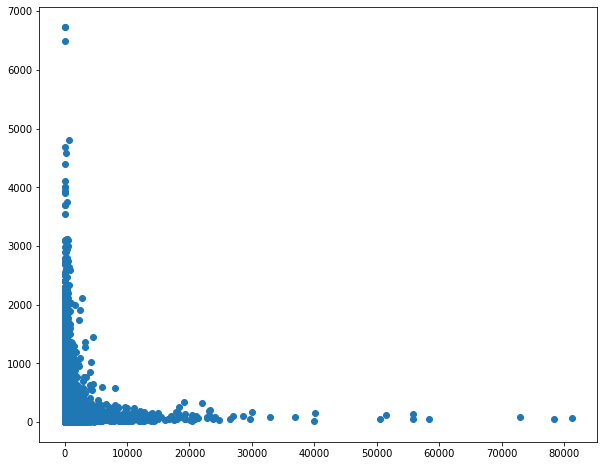

In [131]:
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])

In [146]:
temp_series = temp_df['order_id']['count'].sort_values()[-100:]

In [152]:
temp_df.iloc[temp_series.index.tolist(), ]

,product_id,order_id,price
,,count,mean
15651,7e0dc102074f8285580c9777f79c90cf,10900,35.899
17168,8b50a72d52d7a91fb19d19fbe069e2f2,10939,46.642
14938,7814c273ab16783d73a9863ebfa8b141,11058,237.292
1666,0d85c435fd60b277ffb9e9b0f88f927a,11158,70.802
15825,7fb04722aba7a2b632bac8f9819796f3,11195,81.561
...,...,...,...
6787,368c6c730842d78016ad823897a372db,55853,54.459
7063,389d119b48cf3043d311335e499d9c6b,58319,54.527
18918,99a4788cb24856965c36a24e339b6058,72993,87.811


In [153]:
temp_df = temp_df.iloc[temp_series.index.tolist(), ]

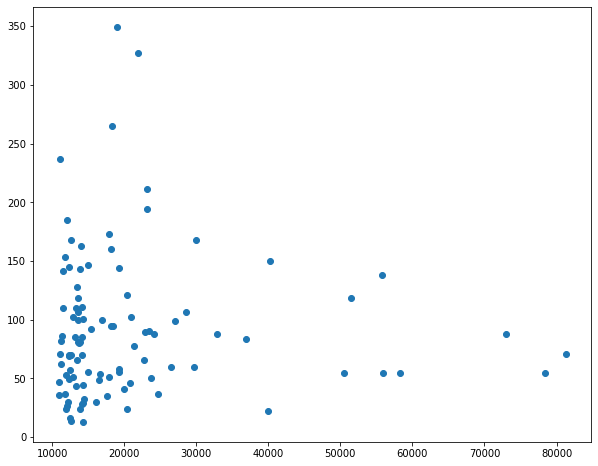

In [154]:
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])

In [155]:
from scipy import stats

# 상관 계수, p-value 순
stats.pearsonr(temp_df['order_id']['count'], temp_df['price']['mean'])

(-0.009396761435840326, 0.926071790002101)

In [156]:
stats.pearsonr([1, 2, 3, 4, 5], [1, 2, 2.5, 4, 4.5])

(0.9878783399072132, 0.0015991373885635269)

----
### [카테고리 주문 비중 분석]

----
#### *카테고리 기초 정보*

In [158]:
order_df['product_category_name_english'].value_counts()

bed_bath_table               1732726
health_beauty                1373356
furniture_decor              1318752
sports_leisure               1309709
computers_accessories        1183370
                              ...   
arts_and_craftmanship           4423
la_cuisine                      2556
cds_dvds_musicals               1413
fashion_childrens_clothes        836
security_and_services            148
Name: product_category_name_english, Length: 71, dtype: int64

<AxesSubplot:>

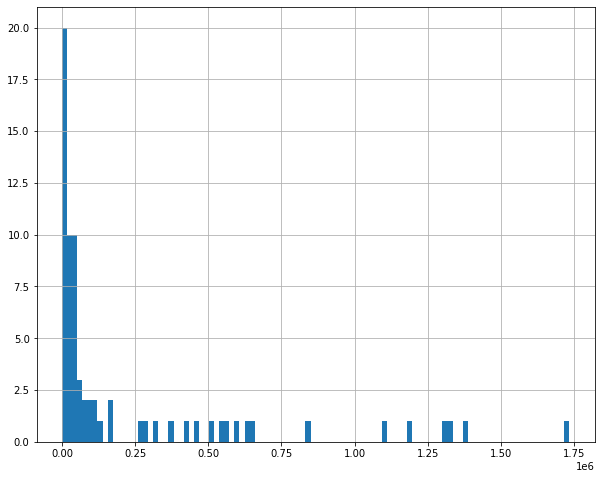

In [163]:
plt.ticklabel_format(style='plain', axis='y')
order_df['product_category_name_english'].value_counts().hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f9d70301160>,
 'caps': [<matplotlib.lines.Line2D at 0x7f9d70301880>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9d702f3d90>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9d70301fa0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f9d7030b370>],
 'means': []}

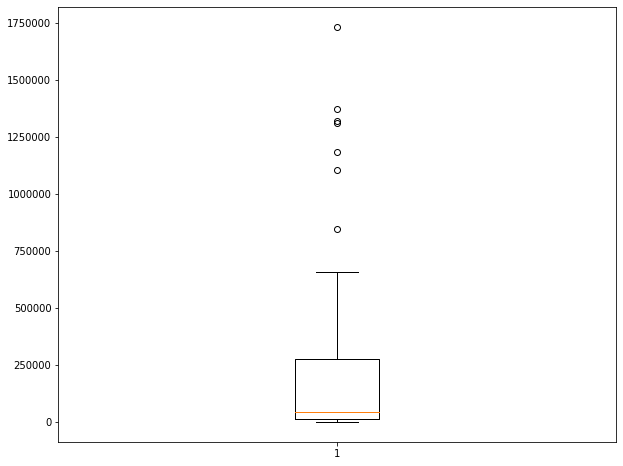

In [162]:
plt.ticklabel_format(style='plain', axis='y')
plt.boxplot(order_df['product_category_name_english'].value_counts())

In [172]:
order_df['product_category_name_english'].value_counts().index[0]

'bed_bath_table'

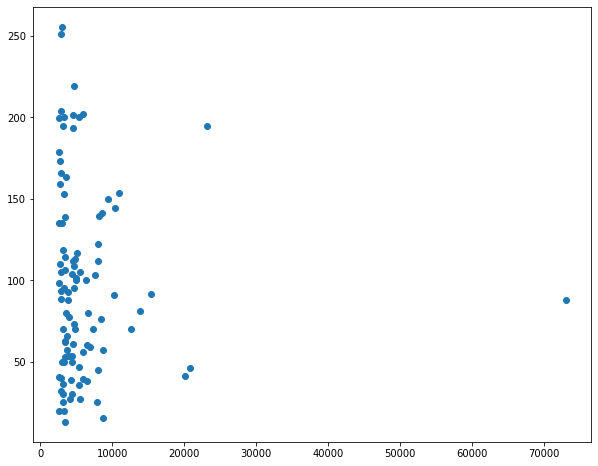

In [173]:
top_sell_category = order_df['product_category_name_english'].value_counts().index[0]
temp_df = order_df[order_df['product_category_name_english']==top_sell_category]
temp_df = temp_df.groupby('product_id').agg({'order_id' : ['count'], 'price' : ['mean']}).reset_index()
temp_series = temp_df['order_id']['count'].sort_values()[-100:]
temp_df = temp_df.iloc[temp_series.index.tolist(), ]
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])

In [174]:
stats.pearsonr(temp_df['order_id']['count'], temp_df['price']['mean'])

(-0.03827222121488914, 0.7053941901860855)

In [175]:
def get_top_n_sell_category_df(df, n):
    top_sell_category = df['product_category_name_english'].value_counts().index[n]
    temp_df = df[df['product_category_name_english']==top_sell_category]
    temp_df = temp_df.groupby('product_id').agg({'order_id' : ['count'], 'price' : ['mean']}).reset_index()
    temp_series = temp_df['order_id']['count'].sort_values()[-100:]
    temp_df = temp_df.iloc[temp_series.index.tolist(), ]
    return temp_df

(-0.06254912649143687, 0.5364216946972725)


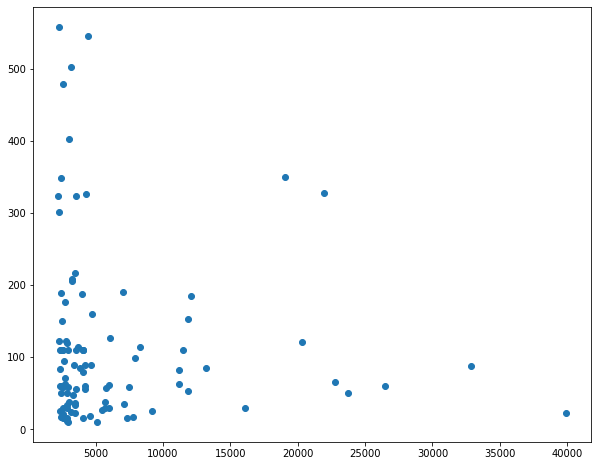

In [177]:
temp_df = get_top_n_sell_category_df(order_df, 1)
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])
print(stats.pearsonr(temp_df['order_id']['count'], temp_df['price']['mean']))

(-0.03796834478552527, 0.7076268748192734)


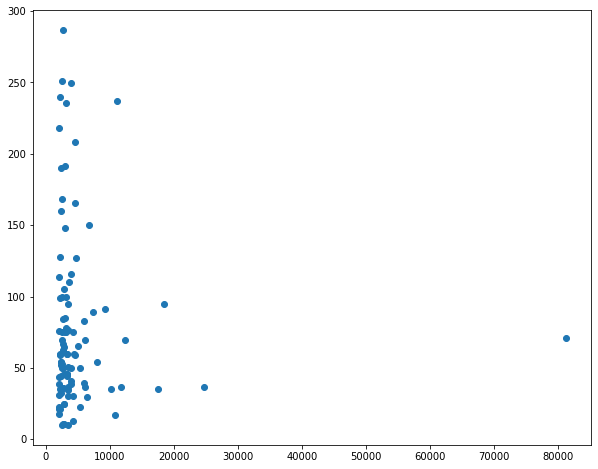

In [178]:
temp_df = get_top_n_sell_category_df(order_df, 2)
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])
print(stats.pearsonr(temp_df['order_id']['count'], temp_df['price']['mean']))

(-0.14632821827072853, 0.1463023253290297)


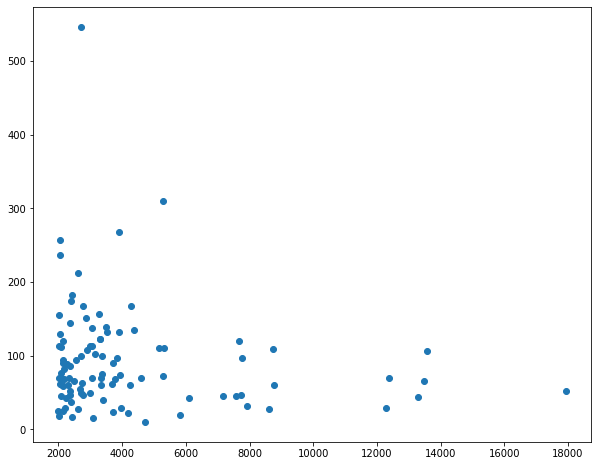

In [179]:
temp_df = get_top_n_sell_category_df(order_df, 3)
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])
print(stats.pearsonr(temp_df['order_id']['count'], temp_df['price']['mean']))

(0.04941146026445566, 0.6254076628266443)


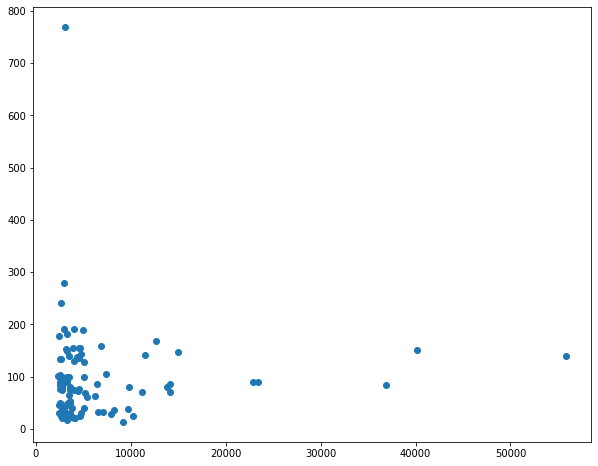

In [180]:
temp_df = get_top_n_sell_category_df(order_df, 4)
plt.scatter(temp_df['order_id']['count'], temp_df['price']['mean'])
print(stats.pearsonr(temp_df['order_id']['count'], temp_df['price']['mean']))

----
#### *카테고리 파이차트*

In [186]:
sum(order_df['product_category_name_english'].value_counts()[:30])

15696630

In [188]:
15696630 / order_df.shape[0]

0.9453475991417292

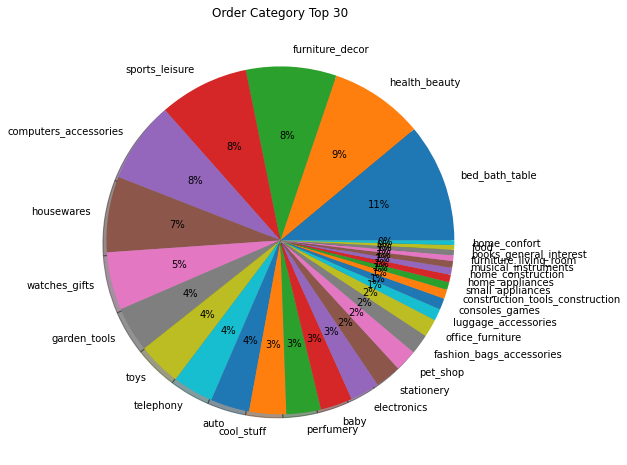

In [191]:
labels = order_df['product_category_name_english'].value_counts()[:30].index.tolist()
fracs1 = order_df['product_category_name_english'].value_counts()[:30].values.tolist()

plt.pie(fracs1, labels=labels, autopct='%.0f%%', shadow=True)
plt.title('Order Category Top 30')
plt.show()

----
### [시간/요일별 주문 카테고리 분석]

In [291]:
temp_df = order_df[order_df['product_category_name_english'].isin(labels)]

In [292]:
temp_df = temp_df[['order_id', 'product_category_name_english', 'order_purchase_day_name']]
temp_df.head()

,order_id,product_category_name_english,order_purchase_day_name
0,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,Wednesday
1,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,Wednesday
2,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,Wednesday
3,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,Wednesday
4,00010242fe8c5a6d1ba2dd792cb16214,cool_stuff,Wednesday


In [293]:
temp_df = temp_df.pivot_table(index='order_purchase_day_name', columns='product_category_name_english', aggfunc='count', fill_value=0).reset_index()

In [294]:
temp_df.head()

order_purchase_day_name order_id         \
product_category_name_english                             auto   baby   
0                                              Friday    82494  64666   
1                                              Monday    93270  78477   
2                                            Saturday    63208  51188   
3                                              Sunday    58256  54418   
4                                            Thursday    90771  68489   

                                                                     \
product_category_name_english bed_bath_table books_general_interest   
0                                     239974                  11178   
1                                     277270                  12740   
2                                     198944                   9214   
3                                     212886                  10660   
4                                     251337                   9508   

                                                                    \
product_category_name_english computers_accessories consoles_games   
0                                            171485          27802   
1                                            208532          30290   
2                                            110617          18771   
3                                            116403          18994   
4                                            178076          20573   

                                                                          \
product_category_name_english construction_tools_construction cool_stuff   
0                                                       21965      80482   
1                                                       21828      82071   
2                                                       13546      57318   
3                                                       18554      66822   
4                                                       23006      75276   

                                           ...                      \
product_category_name_english electronics  ... musical_instruments   
0                                   56553  ...               17307   
1                                   74917  ...               15524   
2                                   47902  ...               12550   
3                                   54458  ...               13756   
4                                   62357  ...               11973   

                                                                   \
product_category_name_english office_furniture perfumery pet_shop   
0                                        41575     75460    46251   
1                                        45771     79416    49328   
2                                        33693     55501    33169   
3                                        18880     66883    47607   
4                                        37454     66080    42804   

                                                                          \
product_category_name_english small_appliances sports_leisure stationery   
0                                        13089         180529      58712   
1                                        14322         210984      54779   
2                                        14886         127802      43115   
3                                        13670         155943      40400   
4                                        20470         197234      53329   

                                                               
product_category_name_english telephony    toys watches_gifts  
0                                 82555   95072        126515  
1                                 96404  105870        137409  
2                                 69402   65144         90685  
3                                 74602   79719        104248  
4                                 87210   85000        131465  

[5 rows x 31 columns]

In [295]:
temp_df.columns = temp_df.columns.to_flat_index()
temp_df.head()

,"(order_purchase_day_name, )","(order_id, auto)","(order_id, baby)","(order_id, bed_bath_table)","(order_id, books_general_interest)","(order_id, computers_accessories)","(order_id, consoles_games)","(order_id, construction_tools_construction)","(order_id, cool_stuff)","(order_id, electronics)",...,"(order_id, musical_instruments)","(order_id, office_furniture)","(order_id, perfumery)","(order_id, pet_shop)","(order_id, small_appliances)","(order_id, sports_leisure)","(order_id, stationery)","(order_id, telephony)","(order_id, toys)","(order_id, watches_gifts)"
0,Friday,82494,64666,239974,11178,171485,27802,21965,80482,56553,...,17307,41575,75460,46251,13089,180529,58712,82555,95072,126515
1,Monday,93270,78477,277270,12740,208532,30290,21828,82071,74917,...,15524,45771,79416,49328,14322,210984,54779,96404,105870,137409
2,Saturday,63208,51188,198944,9214,110617,18771,13546,57318,47902,...,12550,33693,55501,33169,14886,127802,43115,69402,65144,90685
3,Sunday,58256,54418,212886,10660,116403,18994,18554,66822,54458,...,13756,18880,66883,47607,13670,155943,40400,74602,79719,104248
4,Thursday,90771,68489,251337,9508,178076,20573,23006,75276,62357,...,11973,37454,66080,42804,20470,197234,53329,87210,85000,131465


In [296]:
new_columns = []
for tup in temp_df.columns:
    if tup[0] == 'order_id':
        new_columns.append(tup[1])
    else:
        new_columns.append(tup[0])

In [297]:
temp_df.columns = new_columns

In [298]:
temp_df = temp_df.set_index('order_purchase_day_name')

In [299]:
temp_df.head()

,auto,baby,bed_bath_table,books_general_interest,computers_accessories,consoles_games,construction_tools_construction,cool_stuff,electronics,fashion_bags_accessories,...,musical_instruments,office_furniture,perfumery,pet_shop,small_appliances,sports_leisure,stationery,telephony,toys,watches_gifts
order_purchase_day_name,,,,,,,,,,,,,,,,,,,,,
Friday,82494,64666,239974,11178,171485,27802,21965,80482,56553,51826,...,17307,41575,75460,46251,13089,180529,58712,82555,95072,126515
Monday,93270,78477,277270,12740,208532,30290,21828,82071,74917,40771,...,15524,45771,79416,49328,14322,210984,54779,96404,105870,137409
Saturday,63208,51188,198944,9214,110617,18771,13546,57318,47902,29356,...,12550,33693,55501,33169,14886,127802,43115,69402,65144,90685
Sunday,58256,54418,212886,10660,116403,18994,18554,66822,54458,42400,...,13756,18880,66883,47607,13670,155943,40400,74602,79719,104248
Thursday,90771,68489,251337,9508,178076,20573,23006,75276,62357,34631,...,11973,37454,66080,42804,20470,197234,53329,87210,85000,131465


In [350]:
x = new_columns[1:]

d = {}
for i in range(0, 30):
    d["y{0}".format(i)] = temp_df[x[i]].values.tolist()

In [351]:
d

{'y0': [82494, 93270, 63208, 58256, 90771, 93176, 86003],
 'y1': [64666, 78477, 51188, 54418, 68489, 76974, 71070],
 'y2': [239974, 277270, 198944, 212886, 251337, 288703, 263612],
 'y3': [11178, 12740, 9214, 10660, 9508, 12345, 14368],
 'y4': [171485, 208532, 110617, 116403, 178076, 206813, 191444],
 'y5': [27802, 30290, 18771, 18994, 20573, 22423, 24685],
 'y6': [21965, 21828, 13546, 18554, 23006, 15489, 20533],
 'y7': [80482, 82071, 57318, 66822, 75276, 88516, 88218],
 'y8': [56553, 74917, 47902, 54458, 62357, 65452, 64979],
 'y9': [51826, 40771, 29356, 42400, 34631, 45675, 46763],
 'y10': [9211, 14238, 4652, 9579, 9473, 12688, 9284],
 'y11': [207037, 217549, 140887, 172630, 190447, 211065, 179137],
 'y12': [11930, 11624, 9171, 10640, 11380, 15716, 12730],
 'y13': [102556, 106028, 64232, 79057, 101562, 93119, 110618],
 'y14': [188520, 222419, 137261, 165717, 211718, 221222, 226499],
 'y15': [10431, 15823, 12400, 10287, 20514, 19559, 20146],
 'y16': [9191, 8920, 8430, 6598, 10388, 10

In [352]:
day_label = temp_df.index.tolist()

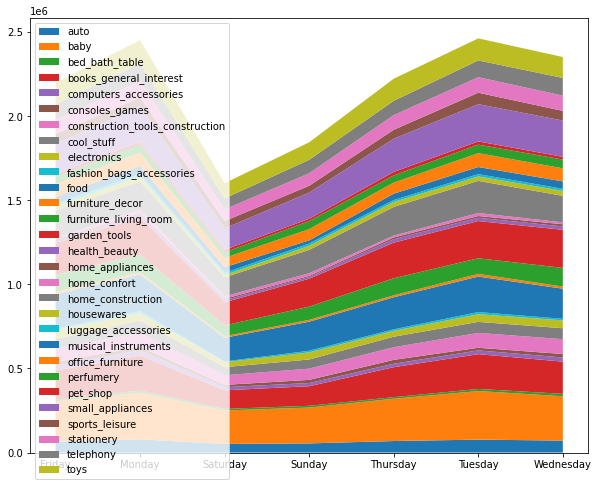

In [355]:
plt.stackplot(day_label,
              d['y1'],d['y2'],d['y3'],d['y4'],d['y5'],d['y6'],d['y7'],d['y8'],d['y9'],d['y10'],
              d['y11'],d['y12'],d['y13'],d['y14'],d['y15'],d['y16'],d['y17'],d['y18'],d['y19'],d['y20'],
              d['y21'],d['y22'],d['y23'],d['y24'],d['y25'],d['y26'],d['y27'],d['y28'],d['y29'],
              labels=x)
plt.legend(loc='upper left')

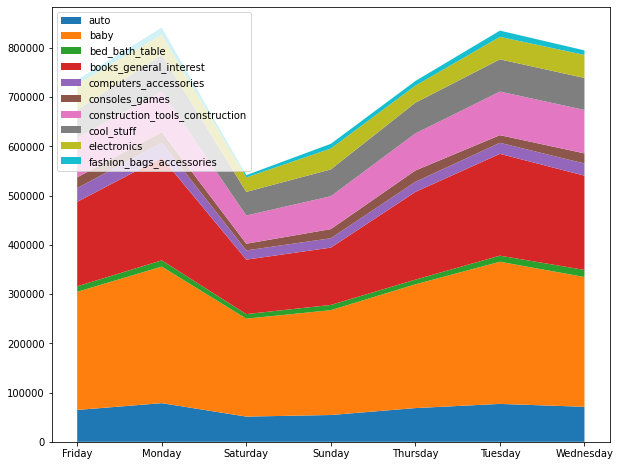

In [356]:
plt.stackplot(day_label,
              d['y1'],d['y2'],d['y3'],d['y4'],d['y5'],d['y6'],d['y7'],d['y8'],d['y9'],d['y10'],
              labels=x)
plt.legend(loc='upper left')

----
# 4. 배송 데이터 분석

### [평균 배송 시간 분석]



----
#### *배송완료까지 걸리는 시간*

In [402]:
order_df[['order_purchase_timestamp', 'order_delivered_customer_date']].head()

,order_purchase_timestamp,order_delivered_customer_date
0,2017-09-13 08:59:02,2017-09-20 23:43:48
1,2017-09-13 08:59:02,2017-09-20 23:43:48
2,2017-09-13 08:59:02,2017-09-20 23:43:48
3,2017-09-13 08:59:02,2017-09-20 23:43:48
4,2017-09-13 08:59:02,2017-09-20 23:43:48


In [410]:
order_df['time_to_delivered'] = order_df['order_delivered_customer_date'] - order_df['order_purchase_timestamp']
order_df['time_to_delivered'].head()

0   7 days 14:44:46
1   7 days 14:44:46
2   7 days 14:44:46
3   7 days 14:44:46
4   7 days 14:44:46
Name: time_to_delivered, dtype: timedelta64[ns]

In [411]:
order_df['time_to_delivered'] = order_df['time_to_delivered'].dt.days

<AxesSubplot:>

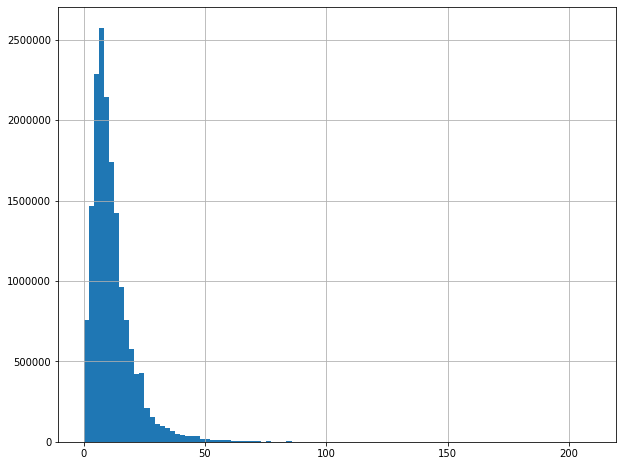

In [415]:
plt.ticklabel_format(style='plain', axis='y')
order_df['time_to_delivered'].hist(bins=100)

In [416]:
order_df['time_to_delivered'].describe()

count   16604083.000
mean          11.766
std            9.110
min            0.000
25%            6.000
50%           10.000
75%           15.000
max          209.000
Name: time_to_delivered, dtype: float64

----
#### *배송완료까지 예상되는 시간*

In [419]:
order_df['time_to_estimated'] = order_df['order_estimated_delivery_date'] - order_df['order_purchase_timestamp']
order_df['time_to_estimated'] = order_df['time_to_estimated'].dt.days
order_df['time_to_estimated'].head()

0    15
1    15
2    15
3    15
4    15
Name: time_to_estimated, dtype: int64

<AxesSubplot:>

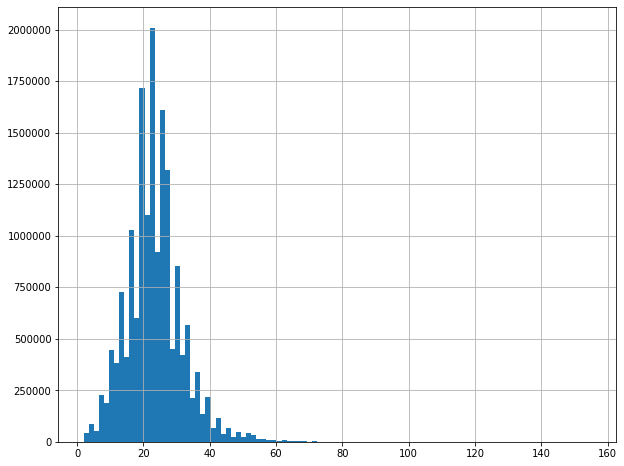

In [420]:
plt.ticklabel_format(style='plain', axis='y')
order_df['time_to_estimated'].hist(bins=100)

In [421]:
order_df['time_to_estimated'].describe()

count   16604083.000
mean          23.465
std            8.553
min            2.000
25%           18.000
50%           23.000
75%           28.000
max          155.000
Name: time_to_estimated, dtype: float64

----
### [지역별 배송 정보 분석]

----
#### *지역 단위의 shipping time 시각화*

<AxesSubplot:>

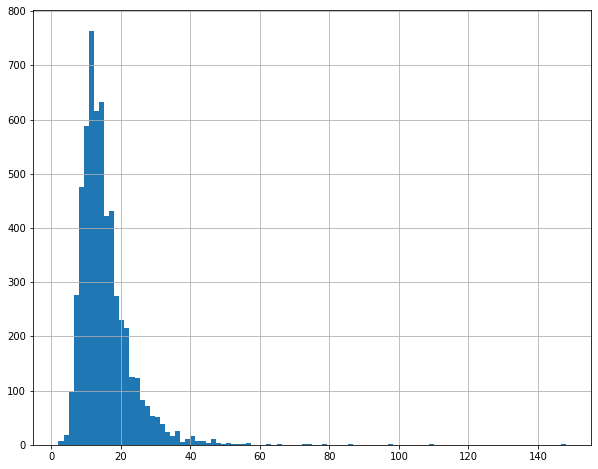

In [424]:
order_df.groupby('city')['time_to_delivered'].mean().hist(bins=100)

<AxesSubplot:>

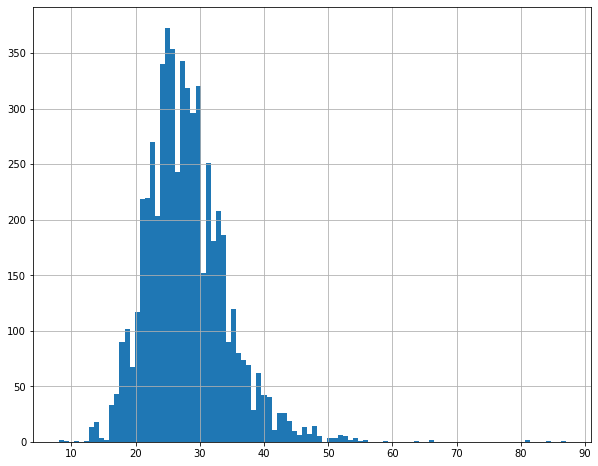

In [425]:
order_df.groupby('city')['time_to_estimated'].mean().hist(bins=100)

----
#### *Bokeh 시각화 - 지역 단위 배송일*

In [427]:
city_df = order_df.groupby('city').agg({'time_to_delivered' : ['mean'], 'lat' : ['mean'], 'lng' : ['mean']})
city_df = city_df.reset_index()
city_df.columns = city_df.columns.to_flat_index()
city_df.columns = ['city', 'time_to_delivered', 'lat', 'lng']
city_df = wgs84_to_web_mercator(city_df, 'lng', 'lat')
city_df.head()

,city,time_to_delivered,lat,lng,x,y
0,* cidade,8.500,-25.572,-49.334,-5491877.401,-2946136.106
1,...arraial do cabo,20.189,-22.969,-42.030,-4678739.761,-2628314.881
2,abadia dos dourados,11.333,-18.474,-47.408,-5277416.222,-2093160.670
3,abadiania,29.000,-16.194,-48.708,-5422198.952,-1827179.099
4,abadiânia,29.000,-16.194,-48.712,-5422610.916,-1827148.419


In [436]:
# Bokh 플롯 개체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = False

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [437]:
def bubble_map(plot, df, count_col, leg_label, lon, lat, scale):
    # color palete 지정
    mapper = LinearColorMapper(
        palette='Magma256',
        low=df[count_col].max(),
        high=df[count_col].min()
    )

    # 지도에 circle 포인트 그리기
    c = plot.circle(x='x',
                    y='y',
                    color=transform(count_col, mapper),
                    size=7,
                    alpha=0.4,
                    source=df,
                    legend_label=leg_label)
    
    # mouse hover에 표기할 정보
    tip_label='@'+count_col
    lat_label='@'+lat
    lon_label='@'+lon
    circle_hover = HoverTool(tooltips=[(count_col, tip_label), ('Lat:', lat_label), ('Lon:', lon_label)], 
                             mode='mouse', 
                             point_policy='follow_mouse', 
                             renderers=[c])
    circle_hover.renderers.append(c)
    
    # mouse hover와 legend 정보 부착
    plot.tools.append(circle_hover)
    plot.legend.location = "top_right"
    plot.legend.click_policy="hide"
    
    # color bar 정보 부착
    color_bar = ColorBar(color_mapper = mapper,
                     label_standoff = 12,
                     location = (0,0),
                     title = 'order count')
    plot.add_layout(color_bar, 'right')

In [438]:
# Create bubble map
bubble_map(plot=plot,
           df=city_df,
           count_col='time_to_delivered', 
           leg_label='Delivered Days Map',
           lon='lng',
           lat='lat',
           scale=zoom_scale)

# plot 시각화
show(plot)

----
#### *Bokeh 시각화 - 지역 단위 배송비*

In [453]:
city_df = order_df.groupby('city').agg({'freight_value' : ['mean'], 'lat' : ['mean'], 'lng' : ['mean']})
city_df = city_df.reset_index()
city_df.columns = city_df.columns.to_flat_index()
city_df.columns = ['city', 'freight_value', 'lat', 'lng']
city_df = wgs84_to_web_mercator(city_df, 'lng', 'lat')
city_df.head()

,city,freight_value,lat,lng,x,y
0,* cidade,16.115,-25.572,-49.334,-5491877.401,-2946136.106
1,...arraial do cabo,30.641,-22.969,-42.030,-4678739.761,-2628314.881
2,abadia dos dourados,18.200,-18.474,-47.408,-5277416.222,-2093160.670
3,abadiania,75.530,-16.194,-48.708,-5422198.952,-1827179.099
4,abadiânia,75.530,-16.194,-48.712,-5422610.916,-1827148.419


<AxesSubplot:>

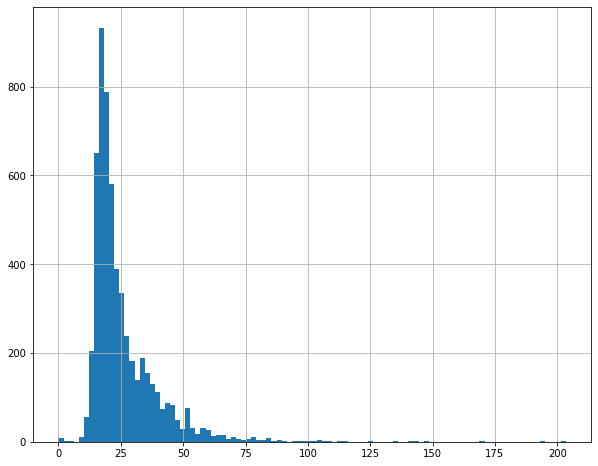

In [454]:
city_df['freight_value'].hist(bins=100)

In [455]:
# Bokh 플롯 개체를 설정하고 지도 타일을 언더레이로 추가.
plot = figure(
    title='E-commerce Order Map',
    match_aspect=True,
    tools='wheel_zoom,pan,reset,save',
    x_range=(x_min, x_max),
    y_range=(y_min, y_max),
    x_axis_type='mercator',
    y_axis_type='mercator',
    width=500
    )

# 지도 그리드 표시
plot.grid.visible = False

map = plot.add_tile(tile_provider)
map.level = 'underlay'

# x와 y축은 숨김.
plot.xaxis.visible = False
plot.yaxis.visible = False

# notebook에 BokehJS 객체 로드
output_notebook()

Loading BokehJS ...

In [457]:
# Create bubble map
bubble_map(plot=plot,
           df=city_df,
           count_col='freight_value', 
           leg_label='Freight Value Map',
           lon='lng',
           lat='lat',
           scale=zoom_scale)

# plot 시각화
show(plot)

----
### [예상 배송일과 실제 배송일 차이 분석]

----
#### *day diff 구하기*

In [439]:
order_df[['order_delivered_customer_date', 'order_estimated_delivery_date']].head()

,order_delivered_customer_date,order_estimated_delivery_date
0,2017-09-20 23:43:48,2017-09-29
1,2017-09-20 23:43:48,2017-09-29
2,2017-09-20 23:43:48,2017-09-29
3,2017-09-20 23:43:48,2017-09-29
4,2017-09-20 23:43:48,2017-09-29


In [440]:
order_df['order_delivered_customer_date'][0].date()

datetime.date(2017, 9, 20)

In [441]:
(order_df['order_estimated_delivery_date'][0].date() - order_df['order_delivered_customer_date'][0].date()).days

9

In [442]:
order_df['estimated_day_diff'] = order_df['order_estimated_delivery_date'] - order_df['order_delivered_customer_date']

In [443]:
order_df['estimated_day_diff'] = order_df['estimated_day_diff'].dt.days

----
#### *day diff 분석*

<AxesSubplot:>

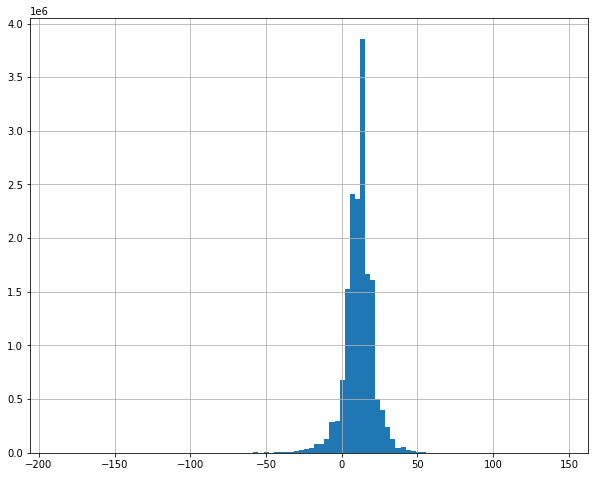

In [444]:
order_df['estimated_day_diff'].hist(bins=100)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f94100600d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f94100607f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f9a394c1e20>],
 'medians': [<matplotlib.lines.Line2D at 0x7f9410060f10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f941006d2e0>],
 'means': []}

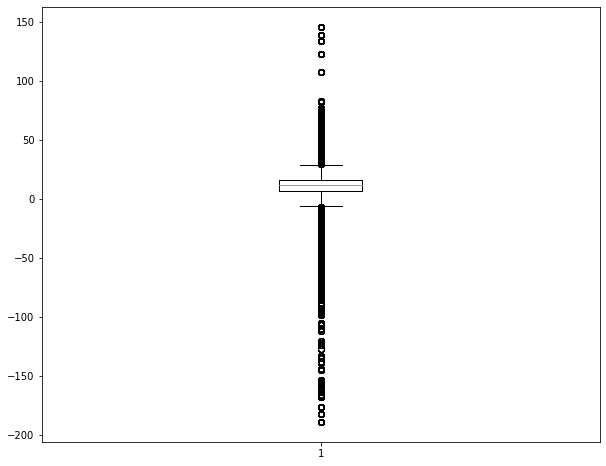

In [445]:
plt.boxplot(order_df['estimated_day_diff'])

In [446]:
order_df['estimated_day_diff'].describe()

count   16604083.000
mean          11.299
std           10.181
min         -189.000
25%            7.000
50%           12.000
75%           16.000
max          146.000
Name: estimated_day_diff, dtype: float64

----
### [카테고리별 배송 데이터 분석]

----
#### *카테고리별 배송기간*

In [461]:
order_df.groupby('product_category_name_english')['time_to_delivered'].mean()

product_category_name_english
agro_industry_and_commerce   11.078
air_conditioning             11.480
art                          10.070
arts_and_craftmanship         5.016
audio                        12.187
                              ...  
stationery                   11.848
tablets_printing_image       11.558
telephony                    11.951
toys                         11.025
watches_gifts                11.686
Name: time_to_delivered, Length: 71, dtype: float64

<AxesSubplot:>

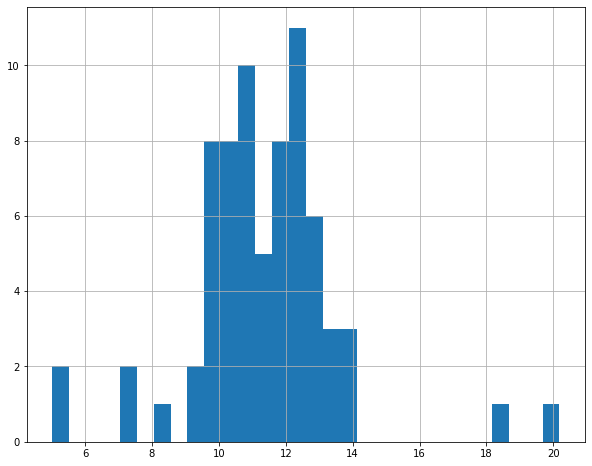

In [465]:
order_df.groupby('product_category_name_english')['time_to_delivered'].mean().hist(bins=30)

In [471]:
order_df.groupby('product_category_name_english')['time_to_delivered'].mean().sort_values()[-10:]

product_category_name_english
computers_accessories     12.849
dvds_blu_ray              13.012
home_comfort_2            13.482
furniture_bedroom         13.505
fashion_male_clothing     13.592
fashion_underwear_beach   13.688
fashion_shoes             13.726
christmas_supplies        13.816
security_and_services     18.568
office_furniture          20.183
Name: time_to_delivered, dtype: float64

----
#### *카테고리별 예상 배송기간*

<AxesSubplot:>

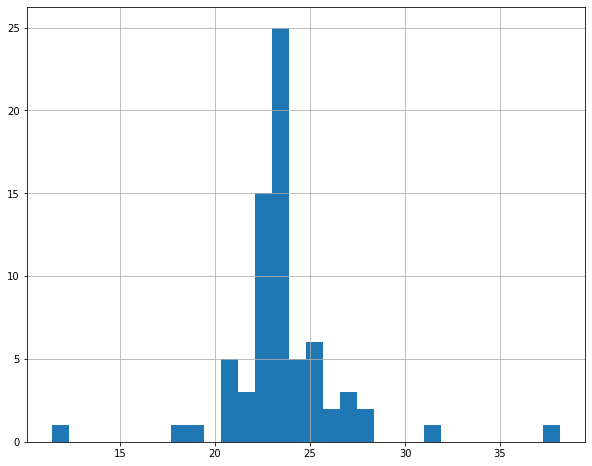

In [466]:
order_df.groupby('product_category_name_english')['time_to_estimated'].mean().hist(bins=30)

In [472]:
order_df.groupby('product_category_name_english')['time_to_estimated'].mean().sort_values()[-10:]

product_category_name_english
air_conditioning        25.659
fixed_telephony         25.819
dvds_blu_ray            25.927
christmas_supplies      26.609
music                   27.020
cds_dvds_musicals       27.333
furniture_bedroom       27.464
fashion_shoes           28.250
office_furniture        31.604
security_and_services   38.135
Name: time_to_estimated, dtype: float64

----
#### *예상보다 빨리 오는 카테고리*

In [476]:
order_df.groupby('product_category_name_english')['estimated_day_diff'].mean().sort_values()[-10:]

product_category_name_english
furniture_bedroom           13.563
market_place                13.579
air_conditioning            13.813
fashion_shoes               14.079
party_supplies              14.105
la_cuisine                  16.151
fashion_childrens_clothes   16.754
music                       16.868
cds_dvds_musicals           17.848
security_and_services       19.568
Name: estimated_day_diff, dtype: float64

----
#### *(비교적)예상보다 늦게 오는 카테고리*

In [477]:
order_df.groupby('product_category_name_english')['estimated_day_diff'].mean().sort_values()[:10]

product_category_name_english
arts_and_craftmanship                6.042
home_comfort_2                       6.965
food                                 8.378
furniture_mattress_and_upholstery    8.433
fashion_underwear_beach              9.221
home_confort                         9.812
diapers_and_hygiene                 10.200
musical_instruments                 10.235
construction_tools_lights           10.346
construction_tools_construction     10.375
Name: estimated_day_diff, dtype: float64

----
# 5. 심화 예제

### [워드 클라우드 예제]

----
#### *리뷰데이터 전처리하기*

In [3]:
olist_order_reviews_dataset = pd.read_csv(data_dir + "olist_order_reviews_dataset.csv")
olist_order_reviews_dataset.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
olist_order_reviews_dataset.shape

(100000, 7)

In [5]:
olist_order_reviews_dataset = olist_order_reviews_dataset[['review_score', 'review_comment_title', 'review_comment_message']]

In [6]:
olist_order_reviews_dataset.isnull().sum()

review_score                  0
review_comment_title      88285
review_comment_message    58247
dtype: int64

In [7]:
olist_order_reviews_dataset = olist_order_reviews_dataset.dropna(how='all', subset=['review_comment_title', 'review_comment_message'])

In [8]:
olist_order_reviews_dataset.isnull().sum()

review_score                  0
review_comment_title      31767
review_comment_message     1729
dtype: int64

In [9]:
olist_order_reviews_dataset = olist_order_reviews_dataset.fillna('')
olist_order_reviews_dataset['text'] = olist_order_reviews_dataset[['review_comment_title', 'review_comment_message']].apply(lambda x : '{}{}'.format(x[0], x[1]), axis=1)

In [10]:
olist_order_reviews_dataset.isnull().sum()

review_score              0
review_comment_title      0
review_comment_message    0
text                      0
dtype: int64

In [11]:
olist_order_reviews_dataset = olist_order_reviews_dataset[['review_score', 'text']]
olist_order_reviews_dataset.head()

,review_score,text
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,recomendoaparelho eficiente. no site a marca d...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Super recomendoVendedor confiável, produto ok ..."


In [12]:
olist_order_reviews_dataset.shape

(43482, 2)

----
#### *포르투갈어 번역하기*

In [13]:
# pip install googletrans==4.0.0-rc1

In [18]:
from googletrans import Translator

# portuguese to english
trans = Translator()
result = trans.translate("Recebi bem antes do prazo estipulado.", src='pt', dest='ko')
result.text

'규정 된 마감일 이전에 잘 받았습니다.'

In [20]:
# olist_order_reviews_dataset['ko_text'] = olist_order_reviews_dataset['text'].apply(lambda x: trans.translate(x, src='pt', dest='ko').text)

In [ ]:
# olist_order_reviews_dataset.to_csv("translated_review.csv", index=False, header=True)

In [25]:
pip install nltk

     |████████████████████████████████| 1.5 MB 1.7 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 4.2 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 4.5 MB/s eta 0:00:01
  Using cached joblib-1.0.1-py3-none-any.whl (303 kB)
     |████████████████████████████████| 97 kB 4.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [28]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
text = " ".join(olist_order_reviews_dataset['text'].values.tolist())
tokens = tokenizer.tokenize(text)

In [29]:
tokens[:10]

['Recebi',
 'bem',
 'antes',
 'do',
 'prazo',
 'estipulado',
 'Parabéns',
 'lojas',
 'lannister',
 'adorei']

In [39]:
from collections import Counter
count = Counter(tokens).most_common(500)

In [40]:
count[:10]

[('e', 15808),
 ('o', 15802),
 ('produto', 14532),
 ('de', 11531),
 ('do', 11200),
 ('a', 10918),
 ('não', 9117),
 ('que', 8488),
 ('prazo', 8239),
 ('muito', 5987)]

In [45]:
ko_count = []
for tup in count:
    ko_count.append((trans.translate(tup[0], src='pt', dest='ko').text, tup[1]))

In [44]:
ko_count[:10]

[('과', 15808),
 ('영형', 15802),
 ('생성물', 14532),
 ('에', 11531),
 ('의', 11200),
 ('그만큼', 10918),
 ('아니', 9117),
 ('뭐', 8488),
 ('마감 시간', 8239),
 ('많은', 5987)]

In [73]:
# 한글자 단어 제거
remove_char_count = [(tup[0], tup[1]) for tup in ko_count if len(tup[0]) > 1]
print(remove_char_count)

[('영형', 15802), ('생성물', 14532), ('그만큼', 10918), ('아니', 9117), ('마감 시간', 8239), ('많은', 5987), ('전에', 5520), ('배달', 5118), ('~에서', 4981), ('이것의', 4355), ('도착했다', 4242), ('였다', 4216), ('나는 받았다', 4038), ('생성물', 3950), ('영형', 3627), ('준다', 3564), ('배달 된 것', 3558), ('...에 대한', 3173), ('그는 온', 3005), ('좋은', 3000), ('...에서', 2967), ('나는 추천한다', 2954), ('품질', 2704), ('그러나', 2650), ('하나', 2615), ('많은', 2317), ('저장', 2199), ('아니', 2188), ('매수', 2151), ('나의', 1884), ('나는 추천한다', 1811), ('나를', 1801), ('그만큼', 1768), ('아직', 1688), ('감독자', 1639), ('처럼', 1535), ('배달', 1519), ('...까지', 1482), ('모두', 1465), ('샀다', 1461), ('빨리', 1437), ('나를', 1400), ('내부', 1386), ('...에 대한', 1376), ('Lannister.', 1336), ('...에서', 1312), ('아침', 1297), ('주문', 1272), ('당신', 1267), ('나의 것', 1233), ('나는 받았다', 1227), ('우수한', 1211), ('인지 어떤지', 1180), ('제품', 1180), ('아니', 1156), ('대지', 1139), ('도착했다', 1129), ('샀다', 1119), ('나는', 1065), ('없이', 1054), ('때문에', 1029), ('같은', 1012), ('좋은', 1009), ('되려고', 987), ('이미', 966), ('빠른', 961), 

In [74]:
# 한국어 약식 불용어사전 예시 파일. 출처 - (https://www.ranks.nl/stopwords/korean)
korean_stopwords_path = "../dataset/korean_stopwords.txt"

# 텍스트 파일을 오픈
with open(korean_stopwords_path, encoding='utf8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


In [75]:
# 키워드 데이터에서 불용어를 제거
remove_char_count = [(tup[0], tup[1]) for tup in remove_char_count if tup[0] not in stopwords]
print(remove_char_count)

[('영형', 15802), ('생성물', 14532), ('그만큼', 10918), ('마감 시간', 8239), ('많은', 5987), ('전에', 5520), ('배달', 5118), ('~에서', 4981), ('이것의', 4355), ('도착했다', 4242), ('였다', 4216), ('나는 받았다', 4038), ('생성물', 3950), ('영형', 3627), ('준다', 3564), ('배달 된 것', 3558), ('...에 대한', 3173), ('그는 온', 3005), ('좋은', 3000), ('...에서', 2967), ('나는 추천한다', 2954), ('품질', 2704), ('많은', 2317), ('저장', 2199), ('매수', 2151), ('나의', 1884), ('나는 추천한다', 1811), ('나를', 1801), ('그만큼', 1768), ('아직', 1688), ('감독자', 1639), ('처럼', 1535), ('배달', 1519), ('...까지', 1482), ('샀다', 1461), ('빨리', 1437), ('나를', 1400), ('내부', 1386), ('...에 대한', 1376), ('Lannister.', 1336), ('...에서', 1312), ('아침', 1297), ('주문', 1272), ('나의 것', 1233), ('나는 받았다', 1227), ('우수한', 1211), ('인지 어떤지', 1180), ('제품', 1180), ('대지', 1139), ('도착했다', 1129), ('샀다', 1119), ('나는', 1065), ('없이', 1054), ('같은', 1012), ('좋은', 1009), ('되려고', 987), ('이미', 966), ('빠른', 961), ('권리', 957), ('며칠', 918), ('그것은', 910), ('매수', 898), ('우수한', 897), ('그것을 좋아했습니다', 891), ('이기는 하지만', 884), ('...에 대

----
#### *워드클라우드 시각화*

In [76]:
# pip install pytagcloud pygame simplejson

  Using cached pytagcloud-0.3.5-py3-none-any.whl
  Using cached pygame-2.0.1-cp38-cp38-macosx_10_9_intel.whl (6.9 MB)
     |████████████████████████████████| 74 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


- 아래 코드 실행을 위해, anaconda prompt 혹은 Terminal에서 아래와 같은 패키지들을 설치해 줍니다.
    - `(env_name) pip install pytagcloud pygame simplejson`
- 그리고 아래와 같은 경로에 한글 폰트(예: NanumBarunGothic.ttf) 파일을 옮깁니다.
    - `Mac OS : /{anaconda_path}/envs/{env_name}/lib/python3.8/site-packages/pytagcloud/fonts`
    - `Windosw OS : {anaconda_path}\envs{env_name}\Lib\site-packages\pytagcloud\fonts`
- 폰트 다운로드 : http://hangeul.naver.com/webfont/NanumGothic/NanumGothic.ttf
    - 파일을 옮긴 후, 파이썬 가상환경을 재실행 하여 주피터를 다시 실행해줍니다. 그래도 아래의 코드가 실행되지 않는 경우는 다음과 같은 작업을 수행합니다.
    - 위의 경로에서 font.json 파일을 편집합니다.
    - 아래와 같은 코드를 추가하고 font.json 파일을 저장합니다.
```
{
      "name": "NanumGothic",
      "ttf": "NanumGothic.ttf",
      "web": "http://fonts.googleapis.com/css?family=Nanum+Gothic"
},
```

In [79]:
# conda info


     active environment : nano
    active env location : /Users/A202009066/anaconda3/envs/nano
            shell level : 2
       user config file : /Users/A202009066/.condarc
 populated config files : 
          conda version : 4.8.3
    conda-build version : 3.18.11
         python version : 3.8.3.final.0
       virtual packages : __osx=10.16
       base environment : /Users/A202009066/anaconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /Users/A202009066/anaconda3/pkgs
                          /Users/A202009066/.conda/pkgs
       envs directories : /Users/A202009066/anaconda3/envs
                          /Users/A202009066/.conda/envs
               platform : osx-64
             user-agent : conda/4.8.3 requests/2.24.0

In [ ]:
# /Users/A202009066/anaconda3/envs/nano/lib/python3.8/site-packages/pytagcloud/fonts

In [4]:
import random
import pytagcloud
import webbrowser

# pytagcloud로 출력할 40개의 단어를 입력합니다. 단어 출력의 최대 크기는 80으로 제한
taglist = pytagcloud.make_tags(remove_char_count, maxsize=80)

# pytagcloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

pygame 2.0.1 (SDL 2.0.14, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


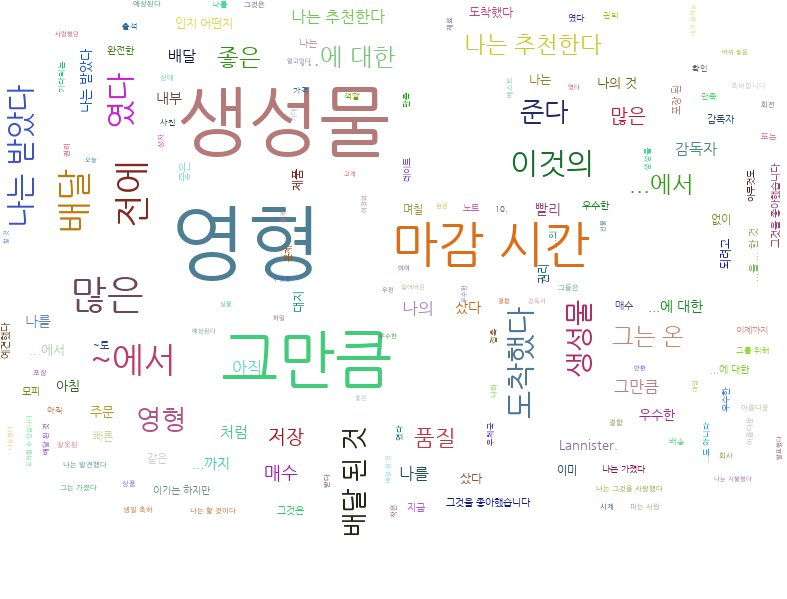

In [5]:
# 생성한 이미지를 주피터 노트북상에서 출력합니다
from IPython.display import Image
Image(filename='wordcloud.jpg')

----
### [감성분류로 텍스트 스코어 추출하기]

----
#### *corpus index 생성하기*

In [48]:
olist_order_reviews_dataset.head()

,review_score,text
3,5,Recebi bem antes do prazo estipulado.
4,5,Parabéns lojas lannister adorei comprar pela I...
9,4,recomendoaparelho eficiente. no site a marca d...
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
15,5,"Super recomendoVendedor confiável, produto ok ..."


In [56]:
olist_order_reviews_dataset['y'] = olist_order_reviews_dataset['review_score'].apply(lambda x: 0 if x < 4 else 1)

In [57]:
olist_order_reviews_dataset.head()

,review_score,text,y
3,5,Recebi bem antes do prazo estipulado.,1
4,5,Parabéns lojas lannister adorei comprar pela I...,1
9,4,recomendoaparelho eficiente. no site a marca d...,1
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",1
15,5,"Super recomendoVendedor confiável, produto ok ...",1


In [50]:
from sklearn.feature_extraction.text import CountVectorizer

def get_token(x):
    return x.split(" ")

# 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
index_vectorizer = CountVectorizer(tokenizer = lambda x: get_token(x))
X = index_vectorizer.fit_transform(olist_order_reviews_dataset['text'].tolist())

In [51]:
X.shape

(43482, 38835)

In [52]:
print(str(index_vectorizer.vocabulary_)[:100]+"..")

{'recebi': 31400, 'bem': 7178, 'antes': 5471, 'do': 14109, 'prazo': 28354, 'estipulado.': 16816, 'pa..


In [53]:
print(olist_order_reviews_dataset['text'].values[0])
print(X[0])

Recebi bem antes do prazo estipulado.
  (0, 31400)	1
  (0, 7178)	1
  (0, 5471)	1
  (0, 14109)	1
  (0, 28354)	1
  (0, 16816)	1


----
#### *TF-IDF로 변환*

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer

# TF-IDF 방법으로, 형태소를 벡터 형태의 학습 데이터셋(X 데이터)으로 변환
tfidf_vectorizer = TfidfTransformer()
X = tfidf_vectorizer.fit_transform(X)

In [55]:
print(X.shape)
print(X[0])

(43482, 38835)
  (0, 31400)	0.3239230387622436
  (0, 28354)	0.31823631854248746
  (0, 16816)	0.7060382455432148
  (0, 14109)	0.2437004791846613
  (0, 7178)	0.3762414414994773
  (0, 5471)	0.30718391965299774


----
#### *로지스틱 회귀분석*

In [58]:
from sklearn.model_selection import train_test_split

y = olist_order_reviews_dataset['y']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
print(x_train.shape)
print(x_test.shape)

(30437, 38835)
(13045, 38835)


In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# 로지스틱 회귀모델을 학습합니다.
lr = LogisticRegression(random_state=0)
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)
y_pred_probability = lr.predict_proba(x_test)[:,1]

# 로지스틱 회귀모델의 성능을 평가합니다.
print("accuracy: %.2f" % accuracy_score(y_test, y_pred))
print("Precision : %.3f" % precision_score(y_test, y_pred))
print("Recall : %.3f" % recall_score(y_test, y_pred))
print("F1 : %.3f" % f1_score(y_test, y_pred))

accuracy: 0.89
Precision : 0.905
Recall : 0.930
F1 : 0.917


In [60]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix를 출력합니다.
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

[[3718  831]
 [ 594 7902]]


AUC : 0.942


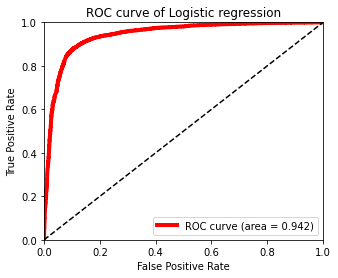

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score

# AUC를 계산합니다.
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred_probability)
roc_auc = roc_auc_score(y_test, y_pred_probability)
print("AUC : %.3f" % roc_auc)

# ROC curve 그래프를 출력합니다.
plt.rcParams['figure.figsize'] = [5, 4]
plt.plot(false_positive_rate, true_positive_rate, label='ROC curve (area = %0.3f)' % roc_auc, 
         color='red', linewidth=4.0)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve of Logistic regression')
plt.legend(loc="lower right")

----
#### *피처 영향력 시각화*

In [63]:
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[:5])
print(sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)[-5:])

[(7.781246197247205, 5471), (4.849716190684731, 35299), (4.1450223522191365, 17152), (3.835533376363966, 4339), (3.5320401505634913, 36785)]
[(-3.904050339183634, 13707), (-4.385491693055707, 4634), (-4.834946549134751, 30372), (-6.199159849074157, 24614), (-10.63333253025742, 25170)]


----
#### *중요 형태소 출력*

In [64]:
# 회귀 모델의 계수를 높은 순으로 정렬합니다. 
coef_pos_index = sorted(((value, index) for index, value in enumerate(lr.coef_[0])), reverse=True)

In [65]:
# 회귀 모델의 계수를 index_vectorizer에 맵핑하여, 어떤 형태소인지 출력할 수 있게 합니다.
invert_index_vectorizer = {v: k for k, v in index_vectorizer.vocabulary_.items()}

In [66]:
# 계수가 높은 순으로, 피처에 형태소를 맵핑한 결과를 출력합니다. 계수가 높은 피처는 리뷰에 긍정적인 영향을 주는 형태소라고 할 수 있습니다.
print(str(invert_index_vectorizer)[:100]+'..')

{31400: 'recebi', 7178: 'bem', 5471: 'antes', 14109: 'do', 28354: 'prazo', 16816: 'estipulado.', 264..


In [69]:
# 상위 20개 긍정 형태소를 출력합니다.
for coef in coef_pos_index[:20]:
    print(trans.translate(invert_index_vectorizer[coef[1]], src='pt', dest='ko'), coef[0])

Translated(src=pt, dest=ko, text=전에, pronunciation=jeon-e, extra_data="{'confiden...") 7.781246197247205
Translated(src=pt, dest=ko, text=감독자, pronunciation=gamdogja, extra_data="{'confiden...") 4.849716190684731
Translated(src=pt, dest=ko, text=큰, pronunciation=keun, extra_data="{'confiden...") 4.1450223522191365
Translated(src=pt, dest=ko, text=나는 그것을 사랑했다, pronunciation=naneun geugeos-eul salanghaessda, extra_data="{'confiden...") 3.835533376363966
Translated(src=pt, dest=ko, text=모두, pronunciation=modu, extra_data="{'confiden...") 3.5320401505634913
Translated(src=pt, dest=ko, text=생일 축하, pronunciation=saeng-il chugha, extra_data="{'confiden...") 3.4778172396952947
Translated(src=pt, dest=ko, text=우수한, pronunciation=usuhan, extra_data="{'confiden...") 3.321236114312626
Translated(src=pt, dest=ko, text=대하여, pronunciation=daehayeo, extra_data="{'confiden...") 3.209874585906335
Translated(src=pt, dest=ko, text=테스트를 거쳤습니다, pronunciation=teseuteuleul geochyeossseubnida, extra_data="{'co

In [70]:
# 상위 20개 부정 형태소를 출력합니다.
for coef in coef_pos_index[-20:]:
    print(trans.translate(invert_index_vectorizer[coef[1]], src='pt', dest='ko'), coef[0])

Translated(src=pt, dest=ko, text=전달, pronunciation=jeondal, extra_data="{'confiden...") -2.5942269496433483
Translated(src=pt, dest=ko, text=내가 원하는, pronunciation=naega wonhaneun, extra_data="{'confiden...") -2.669722543746865
Translated(src=pt, dest=ko, text=나쁜, pronunciation=nappeun, extra_data="{'confiden...") -2.7240463718208625
Translated(src=pt, dest=ko, text=결핍, pronunciation=gyeolpib, extra_data="{'confiden...") -2.7266308764882043
Translated(src=pt, dest=ko, text=부서진, pronunciation=buseojin, extra_data="{'confiden...") -2.752393507808366
Translated(src=pt, dest=ko, text=받침대, pronunciation=badchimdae, extra_data="{'confiden...") -2.825854203603236
Translated(src=pt, dest=ko, text=그는 온, pronunciation=geuneun on, extra_data="{'confiden...") -3.0549501848122502
Translated(src=pt, dest=ko, text=잃어버린, pronunciation=ilh-eobeolin, extra_data="{'confiden...") -3.105566730375109
Translated(src=pt, dest=ko, text=낮은, pronunciation=naj-eun, extra_data="{'confiden...") -3.115437955535704
Tr